# CNGF5020 Group 7 Mini Project

## 0.数据清洗

In [1]:
from pathlib import Path

BASE_DIR = Path(".")  
DATA_DIR = BASE_DIR  
OUT_DIR = BASE_DIR / "outputs"  
OUT_DIR.mkdir(exist_ok=True)

print("当前工作目录：", BASE_DIR.resolve())
print("已创建输出目录：", OUT_DIR.resolve())

当前工作目录： D:\课件\CNGF5020\group_7_mini_project
已创建输出目录： D:\课件\CNGF5020\group_7_mini_project\outputs


In [2]:
!pip install fiona

In [3]:
import fiona, math

SHP_PATH = "CHN_County.shp"   #

PROV_FIELD_CANDIDATES = ["省级", "NAME_1", "province", "Province", "省"]
TARGET_PROV_VALUES = {"黑龙江省", "Heilongjiang"}  

def _geom_bounds(geom: dict):
    if geom is None:
        return None
    gtype = geom.get("type")
    if gtype == "Polygon":
        rings = geom["coordinates"]
    elif gtype == "MultiPolygon":
        rings = []
        for poly in geom["coordinates"]:
            rings += poly
    else:
        return None

    minx, miny, maxx, maxy = math.inf, math.inf, -math.inf, -math.inf
    for ring in rings:
        for x, y in ring:
            if x < minx: minx = x
            if y < miny: miny = y
            if x > maxx: maxx = x
            if y > maxy: maxy = y
    return minx, miny, maxx, maxy

with fiona.open(SHP_PATH, "r") as src:
    fields = list(src.schema["properties"].keys())
    prov_key = None
    for cand in PROV_FIELD_CANDIDATES:
        if cand in fields:
            prov_key = cand
            break
    if prov_key is None:
        raise RuntimeError(f"未找到省份字段。候选={PROV_FIELD_CANDIDATES}；实际字段示例={fields[:15]}")

    found = 0
    minx=miny=  1e9
    maxx=maxy= -1e9
    for feat in src:
        if feat["properties"].get(prov_key) in TARGET_PROV_VALUES:
            b = _geom_bounds(feat["geometry"])
            if b:
                a,bottom,c,d = b
                if a < minx: minx = a
                if bottom < miny: miny = bottom
                if c > maxx: maxx = c
                if d > maxy: maxy = d
                found += 1

heil_bbox = (minx, miny, maxx, maxy)
print(f"识别到黑龙江县级单元数：{found}")
print("黑龙江外接边界框（bbox）=", heil_bbox)

识别到黑龙江县级单元数：128
黑龙江外接边界框（bbox）= (121.18313365009794, 43.42299340532145, 135.08851148002088, 53.56090105044319)


In [4]:
import fiona
with fiona.open("CHN_County.shp") as src:
    print("CRS WKT snippet:", (src.crs_wkt or "")[:120], "...")

CRS WKT snippet: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","632 ...


In [5]:
import pandas as pd

minx, miny, maxx, maxy = heil_bbox 
df10 = pd.read_csv("Satellite Fire Data/modis_2010_China.csv",
                   usecols=["latitude","longitude","acq_date","acq_time","frp"])
sub10 = df10[(df10["longitude"].between(minx, maxx)) & (df10["latitude"].between(miny, maxy))]
print("2010 年黑龙江 bbox 内点数:", len(sub10))
display(sub10.head(3))

2010 年黑龙江 bbox 内点数: 15859


,latitude,longitude,acq_date,acq_time,frp
6667,43.5863,121.2319,2010/2/5,454,7.6
6668,43.5884,121.2446,2010/2/5,454,17.0
15067,43.6830,123.3241,2010/2/23,257,6.7


In [6]:
times = sub10["acq_time"].fillna(0).astype(int).astype(str).str.zfill(4)
dt_str = sub10["acq_date"].astype(str) + " " + times.str[:2] + ":" + times.str[2:]
ts = pd.to_datetime(dt_str, errors="coerce", utc=True)
print("NaT 比例:", ts.isna().mean())
display(pd.DataFrame({"acq_date": sub10["acq_date"].head(5),
                      "acq_time": sub10["acq_time"].head(5),
                      "parsed_ts": ts.head(5)}))

NaT 比例: 0.0


,acq_date,acq_time,parsed_ts
6667,2010/2/5,454,2010-02-05 04:54:00+00:00
6668,2010/2/5,454,2010-02-05 04:54:00+00:00
15067,2010/2/23,257,2010-02-23 02:57:00+00:00
21015,2010/2/28,315,2010-02-28 03:15:00+00:00
21537,2010/2/28,500,2010-02-28 05:00:00+00:00


In [7]:
import pandas as pd
from pathlib import Path

minx, miny, maxx, maxy = heil_bbox 

MODIS_DIR = Path("Satellite Fire Data")   
OUT_DIR   = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

CANDIDATE_COLS = [
    "latitude","longitude","acq_date","acq_time","frp",
    "confidence","satellite","instrument","daynight",
    "type","brightness","bright_t31","scan","track","version"
]

def get_existing_cols(csv_path):
    cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
    return [c for c in CANDIDATE_COLS if c in cols]

def bbox_filter(df):
    return df[(df["longitude"].between(minx, maxx)) & (df["latitude"].between(miny, maxy))]

def add_time_columns(df):
    times = df["acq_time"].fillna(0).astype("Int64").astype(str).str.zfill(4)
    dt_str = df["acq_date"].astype(str) + " " + times.str[:2] + ":" + times.str[2:]
    dt = pd.to_datetime(dt_str, errors="coerce", utc=True)
    return df.assign(
        acq_datetime_utc = dt,
        year  = dt.dt.year.astype("Int16"),
        month = dt.dt.month.astype("Int8"),
        week  = dt.dt.isocalendar().week.astype("Int16"),
    )

modis_paths = sorted(MODIS_DIR.glob("modis_20*_China.csv"))
print("发现 MODIS 文件：", [p.name for p in modis_paths])

CHUNK_SIZE = 200_000
year_counts = []

for p in modis_paths:
    year = int(p.stem.split("_")[1])
    keep_cols = get_existing_cols(p)
    kept = 0
    part_idx = 0

    print(f"\n处理 {p.name} …（保留列：{keep_cols}）")
    dtype_map = {
        "latitude":"float32","longitude":"float32","brightness":"float32",
        "scan":"float32","track":"float32","acq_date":"string","acq_time":"Int64",
        "confidence":"Int64","version":"float32","bright_t31":"float32","frp":"float32",
        "daynight":"string","satellite":"string","instrument":"string","type":"Int16"
    }
    use_dtype = {k: v for k, v in dtype_map.items() if k in keep_cols}

    for chunk in pd.read_csv(p, usecols=keep_cols, dtype=use_dtype, chunksize=CHUNK_SIZE, low_memory=True):
        sub = bbox_filter(chunk)
        if sub.empty:
            continue
        sub = add_time_columns(sub)

        part_idx += 1
        out_part = OUT_DIR / f"_tmp_heil_{year}_{part_idx:03d}.csv.gz"
        sub.to_csv(out_part, index=False, compression="gzip")
        kept += len(sub)

    year_counts.append({"year": year, "points_in_bbox": kept})
    print(f"  年 {year}: 保留 {kept:,} 条")

pd.DataFrame(year_counts).sort_values("year").to_csv(OUT_DIR/"modis_heilongjiang_bbox_counts.csv", index=False, encoding="utf-8-sig")
print("\n完成。分片数量：", len(list(OUT_DIR.glob('_tmp_heil_*.csv.gz'))))

发现 MODIS 文件： ['modis_2010_China.csv', 'modis_2011_China.csv', 'modis_2012_China.csv', 'modis_2013_China.csv', 'modis_2014_China.csv', 'modis_2015_China.csv', 'modis_2016_China.csv', 'modis_2017_China.csv', 'modis_2018_China.csv', 'modis_2019_China.csv']

处理 modis_2010_China.csv …（保留列：['latitude', 'longitude', 'acq_date', 'acq_time', 'frp', 'confidence', 'satellite', 'instrument', 'daynight', 'type', 'brightness', 'bright_t31', 'scan', 'track', 'version']）
  年 2010: 保留 15,859 条

处理 modis_2011_China.csv …（保留列：['latitude', 'longitude', 'acq_date', 'acq_time', 'frp', 'confidence', 'satellite', 'instrument', 'daynight', 'type', 'brightness', 'bright_t31', 'scan', 'track', 'version']）
  年 2011: 保留 28,097 条

处理 modis_2012_China.csv …（保留列：['latitude', 'longitude', 'acq_date', 'acq_time', 'frp', 'confidence', 'satellite', 'instrument', 'daynight', 'type', 'brightness', 'bright_t31', 'scan', 'track', 'version']）
  年 2012: 保留 12,513 条

处理 modis_2013_China.csv …（保留列：['latitude', 'longitude', 'acq_

In [8]:
import pandas as pd, numpy as np, gzip
from pathlib import Path

OUT_DIR = Path("outputs")
parts = sorted(OUT_DIR.glob("_tmp_heil_*.csv.gz"))
assert len(parts) > 0, "没有发现临时分片，请先运行上一个单元。"

final_out = OUT_DIR / "modis_2010_2019_Heilongjiang_bbox.csv.gz"

header_written = False
with gzip.open(final_out, "wt", newline="") as fout:
    for part in parts:
        for chunk in pd.read_csv(part, chunksize=200_000, low_memory=True):
            chunk.to_csv(fout, index=False, header=not header_written)
            header_written = True

print("已写出：", final_out)

agg = {}
for chunk in pd.read_csv(final_out, usecols=["year","frp"], chunksize=400_000, low_memory=True):
    grp = chunk.groupby("year")["frp"].agg(["size","sum"])
    for y, row in grp.iterrows():
        y = int(y)
        d = agg.setdefault(y, {"n":0, "sum":0.0})
        d["n"] += int(row["size"])
        d["sum"] += float(row["sum"])

summary = []
for y in sorted(agg):
    n = agg[y]["n"]; s = agg[y]["sum"]
    summary.append({"year": y, "n_points": n, "frp_mean": (s/n if n>0 else np.nan)})

frp_by_year = {row["year"]: [] for row in summary}
for chunk in pd.read_csv(final_out, usecols=["year","frp"], chunksize=400_000, low_memory=True):
    for y, sub in chunk.groupby("year"):
        frp_by_year[int(y)].extend(sub["frp"].dropna().tolist())

for row in summary:
    arr = sorted(frp_by_year[row["year"]])
    if arr:
        mid = len(arr)//2
        row["frp_median"] = arr[mid] if len(arr)%2==1 else (arr[mid-1]+arr[mid])/2
    else:
        row["frp_median"] = np.nan

summary_df = pd.DataFrame(summary)
summary_df.to_csv(OUT_DIR/"modis_heilongjiang_bbox_year_summary.csv", index=False, encoding="utf-8-sig")
summary_df

已写出： outputs\modis_2010_2019_Heilongjiang_bbox.csv.gz


,year,n_points,frp_mean,frp_median
0,2010,15859,21.062299,10.3
1,2011,28097,17.366231,9.3
2,2012,12513,18.108463,9.8
3,2013,19272,15.950519,9.5
4,2014,45225,15.665046,9.8
5,2015,45957,20.065718,12.0
6,2016,32647,18.130110,10.8
7,2017,48111,18.839280,11.4
8,2018,18648,16.603159,9.5
9,2019,23939,20.104628,11.0


In [9]:
df = pd.read_csv("outputs/modis_2010_2019_Heilongjiang_bbox.csv.gz")
print(df.shape)
print(df.columns.tolist())
df.head()

(290268, 19)
['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type', 'acq_datetime_utc', 'year', 'month', 'week']


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,acq_datetime_utc,year,month,week
0,43.5863,121.2319,300.8,1.0,1.0,2010/2/5,454,Aqua,MODIS,42,6.2,271.3,7.6,D,0,2010-02-05 04:54:00+00:00,2010,2,5
1,43.5884,121.2446,314.3,1.0,1.0,2010/2/5,454,Aqua,MODIS,75,6.2,271.7,17.0,D,0,2010-02-05 04:54:00+00:00,2010,2,5
2,43.6830,123.3241,300.8,1.1,1.0,2010/2/23,257,Terra,MODIS,41,6.2,275.4,6.7,D,0,2010-02-23 02:57:00+00:00,2010,2,8
3,44.9411,121.5900,328.6,1.3,1.1,2010/2/28,315,Terra,MODIS,86,6.2,273.4,44.7,D,0,2010-02-28 03:15:00+00:00,2010,2,8
4,44.9317,121.5888,311.0,1.0,1.0,2010/2/28,500,Aqua,MODIS,71,6.2,275.8,12.0,D,0,2010-02-28 05:00:00+00:00,2010,2,8


## 1.Core Question 1

In [10]:
#Cell 1 — 读取全国火点并做时间字段
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("Satellite Fire Data")
usecols = ["latitude","longitude","acq_date","acq_time","frp"]

def load_all_years():
    parts = []
    for y in range(2010, 2019+1):
        p = DATA_DIR / f"modis_{y}_China.csv"
        df = pd.read_csv(p, usecols=usecols, low_memory=True)
        # 统一时间
        t = df["acq_time"].fillna(0).astype(int).astype(str).str.zfill(4)
        dt = pd.to_datetime(df["acq_date"].astype(str) + " " + t.str[:2] + ":" + t.str[2:], errors="coerce", utc=True)
        df["dt"] = dt
        df["date"] = df["dt"].dt.date
        df["year"] = df["dt"].dt.year
        df["week"] = df["dt"].dt.isocalendar().week.astype(int)  # 1–53
        df["month"] = df["dt"].dt.month
        parts.append(df)
    out = pd.concat(parts, ignore_index=True)
    # 合理经纬度约束（中国外点去掉，避免极端噪声）
    out = out.query("18<=latitude<=54 and 73<=longitude<=135").copy()
    return out

fires = load_all_years()
len(fires), fires.head(3)

(1073117,
    latitude  longitude  acq_date  acq_time   frp                        dt  \
 0   30.8759   120.1314  2010/1/1       242   7.5 2010-01-01 02:42:00+00:00   
 1   28.6087   121.4316  2010/1/1       243  10.1 2010-01-01 02:43:00+00:00   
 2   27.0163   102.2247  2010/1/1       422  14.5 2010-01-01 04:22:00+00:00   
 
          date  year  week  month  
 0  2010-01-01  2010    53      1  
 1  2010-01-01  2010    53      1  
 2  2010-01-01  2010    53      1  )

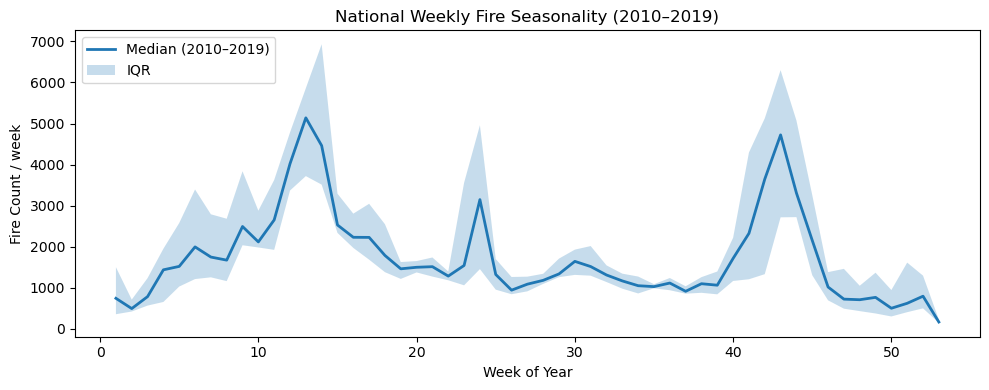

In [11]:
#Cell 2 — 全国“周气候学”季节性（中位数 + IQR）
import matplotlib.pyplot as plt

wk_year = fires.groupby(["year","week"]).size().rename("n").reset_index()
wk_clim = (wk_year.groupby("week")["n"]
           .agg(med="median", p25=lambda x: x.quantile(0.25), p75=lambda x: x.quantile(0.75))
           .reset_index())

plt.figure(figsize=(10,4))
plt.plot(wk_clim["week"], wk_clim["med"], lw=2, label="Median (2010–2019)")
plt.fill_between(wk_clim["week"], wk_clim["p25"], wk_clim["p75"], alpha=0.25, label="IQR")
plt.title("National Weekly Fire Seasonality (2010–2019)")
plt.xlabel("Week of Year"); plt.ylabel("Fire Count / week")
plt.legend(); plt.tight_layout(); plt.show()


In [12]:
import geopandas as gpd

gdf = gpd.read_file("CHN_County.shp")
gdf.head(), gdf.columns

(     地名       区划码    县级       县级码  县级类           地级       地级码  地级类        省级  \
 0  阿巴嘎旗  152522.0  阿巴嘎旗  152522.0    旗        锡林郭勒盟  152500.0    盟    内蒙古自治区   
 1   阿坝县  513231.0   阿坝县  513231.0    县    阿坝藏族羌族自治州  513200.0  自治州       四川省   
 2   阿城区  230112.0   阿城区  230112.0  市辖区         哈尔滨市  230100.0  地级市      黑龙江省   
 3  阿尔山市  152202.0  阿尔山市  152202.0  县级市          兴安盟  152200.0    盟    内蒙古自治区   
 4  阿合奇县  653023.0  阿合奇县  653023.0    县  克孜勒苏柯尔克孜自治州  653000.0  自治州  新疆维吾尔自治区   
 
         省级码  ...            NAME_2 VAR_NAME2     GID_2 TYPE_2        NAME_1  \
 0  150000.0  ...        Xilinguole      None  152500.0   None     Neimenggu   
 1  510000.0  ...  Abazangzuqiangzu      None  513200.0   None       Sichuan   
 2  230000.0  ...           Haerbin      None  230100.0   None  Heilongjiang   
 3  150000.0  ...            Xingan      None  152200.0   None     Neimenggu   
 4  650000.0  ...  Kezilesukeerkezi      None  653000.0   None      Xinjiang   
 
         VAR_NAME1     GID_1  

In [13]:
import geopandas as gpd
import pandas as pd

# 1. 读入中国县级数据
china = gpd.read_file("CHN_County.shp")[["geometry","NAME_1"]]
china = china.rename(columns={"NAME_1": "province"})

# 2. 火点转 GeoDataFrame
fires_gdf = gpd.GeoDataFrame(
    fires,
    geometry=gpd.points_from_xy(fires.longitude, fires.latitude),
    crs="EPSG:4326"
)

# 3. 空间连接：点落在哪个行政区
fires_join = gpd.sjoin(fires_gdf, china, how="left", predicate="within")

# 4. 加入 province 字段
fires["province"] = fires_join["province"]

# 5. 查看前几行
fires[['date','longitude','latitude','province']].head()

,date,longitude,latitude,province
0,2010-01-01,120.1314,30.8759,Zhejiang
1,2010-01-01,121.4316,28.6087,Zhejiang
2,2010-01-01,102.2247,27.0163,Sichuan
3,2010-01-01,101.6699,26.5719,Sichuan
4,2010-01-01,100.6149,27.8552,Yunnan


In [14]:
fires['province'].value_counts().head(10)

province
Heilongjiang    206929
Neimenggu        79870
Yunnan           65057
Jilin            59069
Guangxi          55969
Liaoning         49446
Anhui            47705
Guangdong        46739
Hebei            45982
Shandong         43750
Name: count, dtype: int64

In [15]:
#Cell 3 — 省级“热点周”（z-score 异常）+ 结果表

TOP_K = 2         
USE_ROBUST = False 

import numpy as np
import pandas as pd

need_cols = {"province","year","week"}
assert need_cols.issubset(fires.columns), f"缺少列：{need_cols - set(fires.columns)}"

pv_wk = (
    fires.groupby(["province","year","week"])
         .size().rename("n").reset_index()
)

base = (
    pv_wk.groupby(["province","week"])["n"]
         .agg(mu="mean", sd="std", p50="median")
         .reset_index()
)

pv_wk_z = pv_wk.merge(base, on=["province","week"], how="left")
pv_wk_z["z"] = (pv_wk_z["n"] - pv_wk_z["mu"]) / pv_wk_z["sd"].replace(0, np.nan)
pv_wk_z["z"] = pv_wk_z["z"].fillna(0.0)

mad_base = (
    pv_wk.groupby(["province","week"])["n"]
         .agg(med="median", mad=lambda x: (np.abs(x - np.median(x))).median())
         .reset_index()
)
pv_wk_rz = pv_wk.merge(mad_base, on=["province","week"], how="left")
pv_wk_rz["robust_z"] = (pv_wk_rz["n"] - pv_wk_rz["med"]) / (1.4826 * pv_wk_rz["mad"].replace(0, np.nan))
pv_wk_rz["robust_z"] = pv_wk_rz["robust_z"].fillna(0.0)

score_col = "robust_z" if USE_ROBUST else "z"
pv_use = pv_wk_rz if USE_ROBUST else pv_wk_z

hot_weeks = (
    pv_use.sort_values(["province", score_col], ascending=[True, False])
          .groupby("province")
          .head(TOP_K)
          .sort_values(["province", score_col], ascending=[True, False])
          .reset_index(drop=True)
)

print(f"使用分数：{score_col}；每省 Top{TOP_K} 异常周。")
display(hot_weeks.head(20))

hot_weeks.to_csv(f"outputs/hot_weeks_top{TOP_K}_{score_col}.csv", index=False)

clim = (
    pv_wk.groupby(["province","week"])["n"]
         .agg(med="median", p25=lambda x: x.quantile(0.25), p75=lambda x: x.quantile(0.75))
         .reset_index()
)

clim_peak = clim.sort_values(["province","med"], ascending=[True, False]).groupby("province").head(1)
clim_peak.to_csv("outputs/province_peak_week_climatology.csv", index=False)
display(clim_peak.head(20))

使用分数：z；每省 Top2 异常周。


,province,year,week,n,mu,sd,p50,z
0,Anhui,2010,25,2194,306.400000,674.123826,65.5,2.800079
1,Anhui,2012,39,148,26.500000,43.559028,13.0,2.789318
2,Beijing,2013,31,33,9.500000,8.834906,7.5,2.659904
3,Beijing,2013,35,45,10.900000,13.067772,6.0,2.609473
4,Chongqing,2018,32,111,38.600000,29.405971,30.5,2.462085
5,Chongqing,2018,23,60,12.375000,19.624602,6.5,2.426801
6,Fujian,2010,44,77,24.100000,19.823947,18.0,2.668490
7,Fujian,2011,9,450,88.300000,137.793767,24.5,2.624937
8,Gansu,2019,14,139,26.600000,40.274613,12.5,2.790840
9,Gansu,2019,13,121,31.600000,32.184192,23.0,2.777761


,province,week,med,p25,p75
23,Anhui,24,572.5,60.75,1711.75
82,Beijing,30,27.0,5.00,30.50
135,Chongqing,30,50.0,26.25,76.50
165,Fujian,8,101.0,7.00,135.00
253,Gansu,43,47.0,40.00,54.00
266,Guangdong,3,163.5,34.75,239.25
322,Guangxi,6,175.0,100.00,294.00
375,Guizhou,6,119.0,8.25,318.75
434,Hainan,12,19.5,5.00,23.75
499,Hebei,24,281.0,188.25,367.75


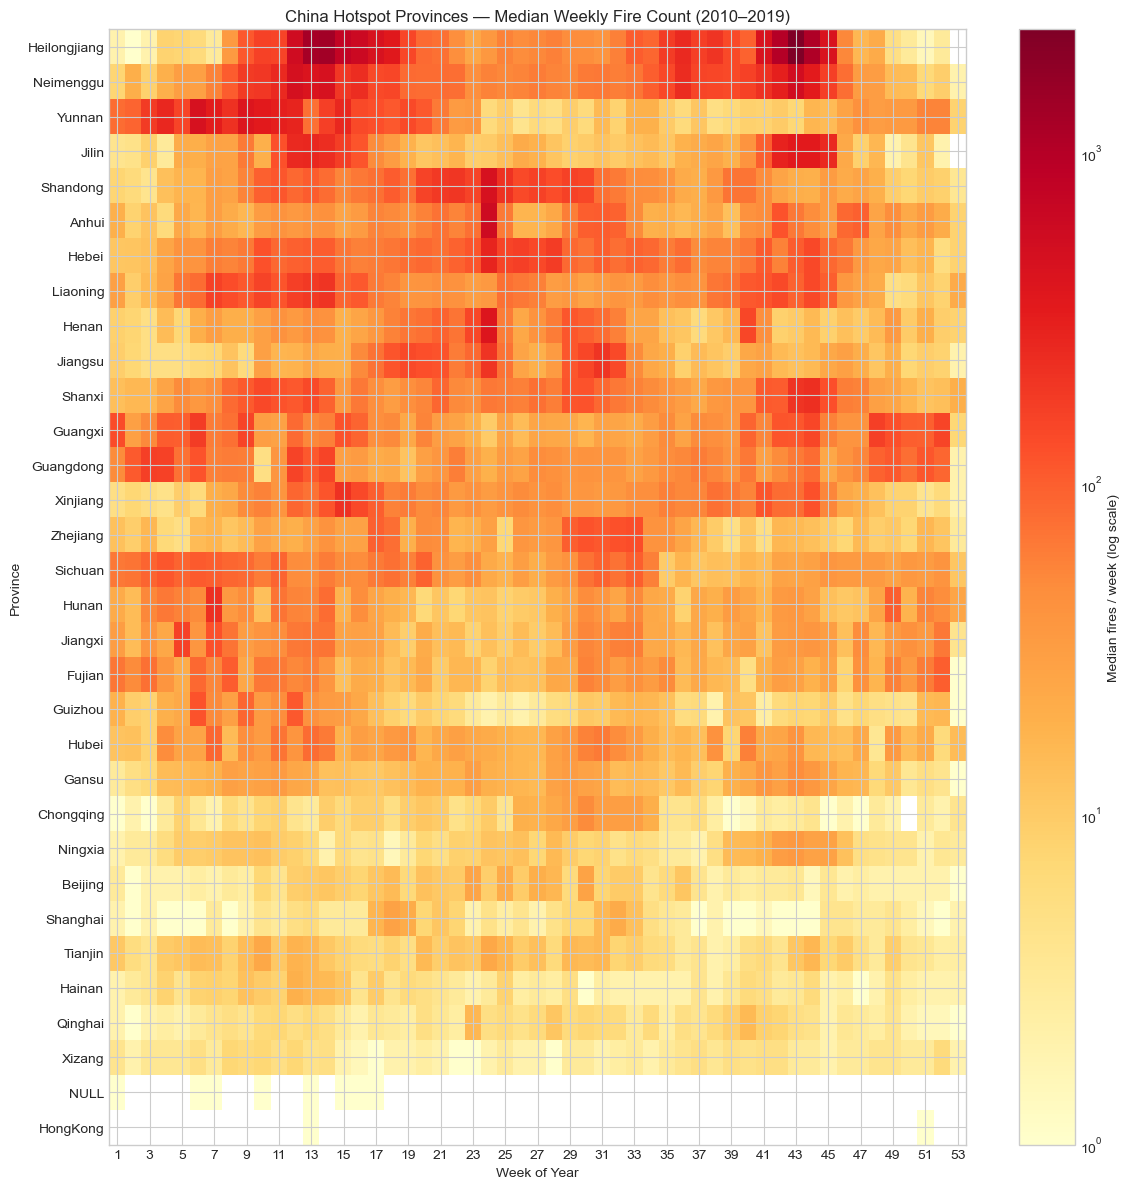

In [16]:
# ==== China hotspot provinces heatmap (province × week) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm

plt.style.use("seaborn-v0_8-whitegrid")

# 1) 逐省 × 年 × 周 计数
wk = (fires
      .loc[fires["week"].between(1, 53)]
      .groupby(["province","year","week"])
      .size()
      .rename("n")
      .reset_index())

# 2) 在省内对 2010–2019 聚合（中位数 + IQR 可选）
agg = (wk.groupby(["province","week"])["n"]
         .agg(med="median",
              p25=lambda x: x.quantile(0.25),
              p75=lambda x: x.quantile(0.75))
         .reset_index())

# 3) 透视：省 × 周（值 = 中位数）
pv = (agg.pivot(index="province", columns="week", values="med")
         .fillna(0)
         .astype(float))

# 4) 省排序：按“最热前6个周”的和（你也可改成总和/最大值/95分位等）
hotness = pv.apply(lambda r: r.nlargest(6).sum(), axis=1)
pv = pv.loc[hotness.sort_values(ascending=False).index]

# 5) 画热力图（对数色标，避免大省/小省差距淹没）
vmin = max(1, pv.values[pv.values>0].min()) if (pv.values>0).any() else 1
vmax = pv.values.max() if pv.values.max() > 0 else 1

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(pv.values,
               aspect="auto",
               interpolation="nearest",
               cmap="YlOrRd",
               norm=LogNorm(vmin=vmin, vmax=vmax))

ax.set_title("China Hotspot Provinces — Median Weekly Fire Count (2010–2019)")
ax.set_xlabel("Week of Year")
ax.set_ylabel("Province")

# x 轴周数：隔周标一次更清晰
xticks = np.arange(1, 54, 2)
ax.set_xticks(xticks-1)               # 列索引从0开始
ax.set_xticklabels(xticks)

# 省名
ax.set_yticks(np.arange(len(pv.index)))
ax.set_yticklabels(pv.index)

cbar = fig.colorbar(im, ax=ax, label="Median fires / week (log scale)")
plt.tight_layout()
plt.show()

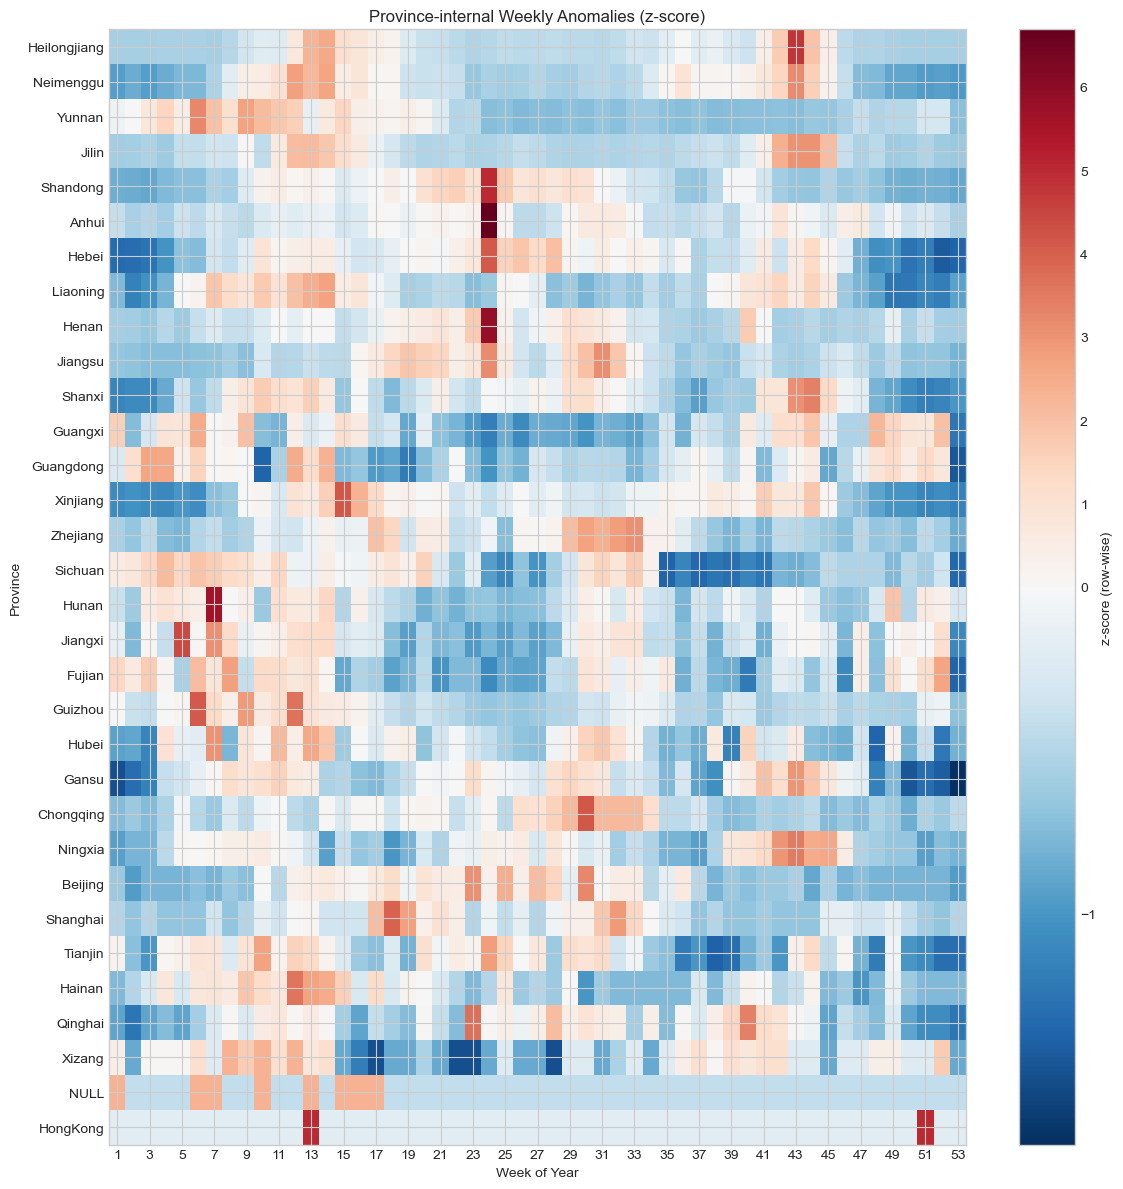

In [17]:
# Row-wise z-score heatmap (province-internal anomalies)
pv_z = pv.copy()
row_mean = pv_z.mean(axis=1).values[:, None]
row_std  = pv_z.std(axis=1).replace(0, np.nan).values[:, None]
pv_z = (pv_z - row_mean) / row_std
pv_z = pv_z.fillna(0)

fig2, ax2 = plt.subplots(figsize=(12, 12))
im2 = ax2.imshow(pv_z.values, aspect="auto", interpolation="nearest",
                 cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0.0))
ax2.set_title("Province-internal Weekly Anomalies (z-score)")
ax2.set_xlabel("Week of Year"); ax2.set_ylabel("Province")
ax2.set_xticks(xticks-1); ax2.set_xticklabels(xticks)
ax2.set_yticks(np.arange(len(pv.index))); ax2.set_yticklabels(pv.index)
fig2.colorbar(im2, ax=ax2, label="z-score (row-wise)")
plt.tight_layout(); plt.show()

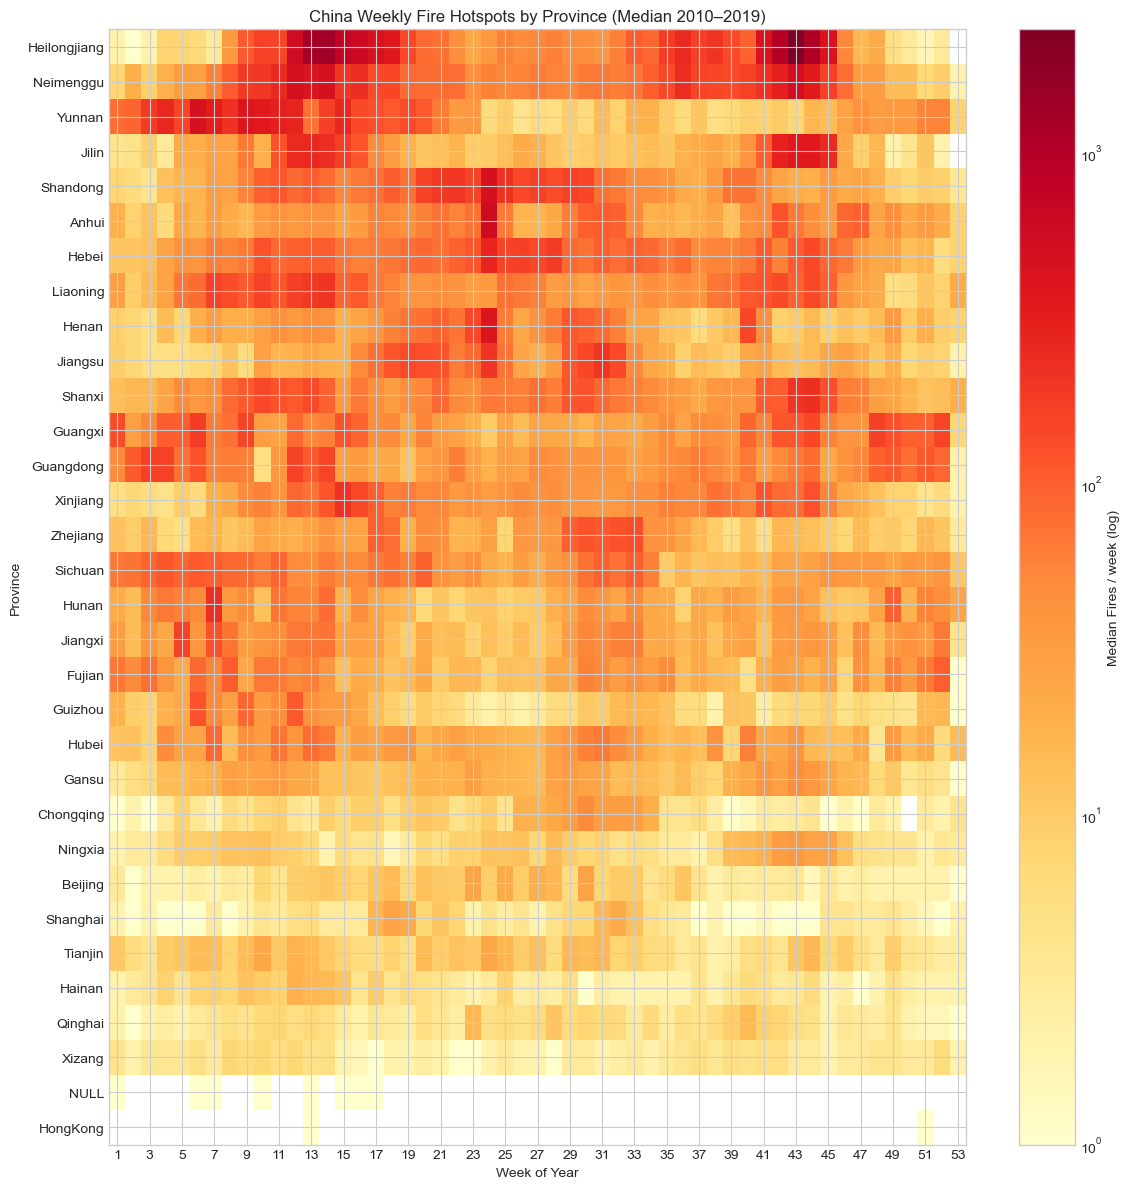

In [18]:
#Cell 4 — 省级“峰值周”地图
wk = (fires
      .loc[fires["week"].between(1, 53)]
      .groupby(["province","year","week"])
      .size().rename("n").reset_index())

# 2) median by province-week
agg = (wk.groupby(["province","week"])["n"]
         .agg(med="median",
              p25=lambda x: x.quantile(0.25),
              p75=lambda x: x.quantile(0.75))
         .reset_index())

# 3) pivot to Province × Week matrix
pv = (agg.pivot(index="province", columns="week", values="med")
         .fillna(0).astype(float))

# 4) rank provinces by peak intensity (top 6 weeks sum)
hotness = pv.apply(lambda r: r.nlargest(6).sum(), axis=1)
pv = pv.loc[hotness.sort_values(ascending=False).index]

# 5) plot heatmap (log color scale)
vmin = max(1, pv.values[pv.values>0].min())
vmax = pv.values.max()

fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(pv.values,
               aspect="auto",
               cmap="YlOrRd",
               norm=LogNorm(vmin=vmin, vmax=vmax))

ax.set_title("China Weekly Fire Hotspots by Province (Median 2010–2019)")
ax.set_xlabel("Week of Year")
ax.set_ylabel("Province")

xticks = np.arange(1, 54, 2)
ax.set_xticks(xticks-1)
ax.set_xticklabels(xticks)
ax.set_yticks(np.arange(len(pv.index)))
ax.set_yticklabels(pv.index)

fig.colorbar(im, ax=ax, label="Median Fires / week (log)")
plt.tight_layout()
plt.show()

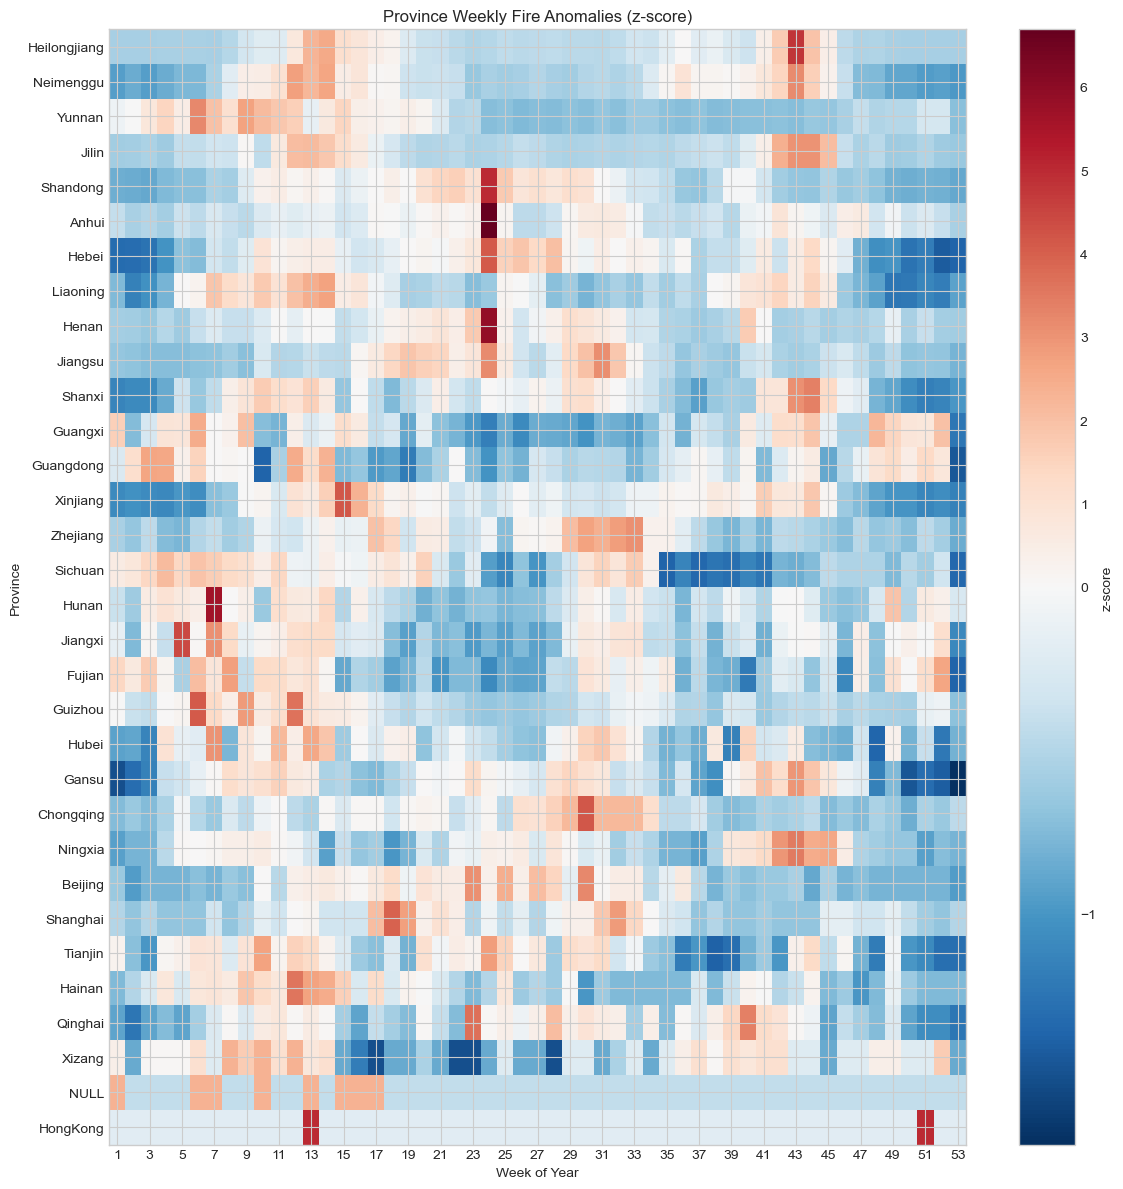

In [19]:
#Cell 5 — 县 × 周热图（全国 Top N 县）
pv_z = pv.copy()
row_mean = pv_z.mean(axis=1).values[:, None]
row_std  = pv_z.std(axis=1).replace(0, np.nan).values[:, None]
pv_z = (pv_z - row_mean) / row_std
pv_z = pv_z.fillna(0)

fig2, ax2 = plt.subplots(figsize=(12,12))
im2 = ax2.imshow(pv_z.values, aspect="auto",
                 cmap="RdBu_r",
                 norm=TwoSlopeNorm(vcenter=0))

ax2.set_title("Province Weekly Fire Anomalies (z-score)")
ax2.set_xlabel("Week of Year"); ax2.set_ylabel("Province")
ax2.set_xticks(xticks-1); ax2.set_xticklabels(xticks)
ax2.set_yticks(np.arange(len(pv_z.index)))
ax2.set_yticklabels(pv_z.index)

fig2.colorbar(im2, ax=ax2, label="z-score")
plt.tight_layout(); plt.show()

In [20]:
#Cell 6 — 县级季内模式聚类（KMeans）+ 地图
top_weeks = (wk
    .groupby(["province","week"])["n"]
    .agg(mu="mean", sd="std", p50="median")
    .reset_index())

top_weeks["z"] = (top_weeks["p50"] - top_weeks.groupby("province")["p50"].transform("mean")) / \
                 (top_weeks.groupby("province")["p50"].transform("std"))

# pick top 2 weeks per province
hot_weeks = (top_weeks.sort_values(["province","z"], ascending=[True,False])
                       .groupby("province").head(2)
                       .sort_values(["province","z"], ascending=[True,False]))

hot_weeks.head(15)

,province,week,mu,sd,p50,z
23,Anhui,24,1091.900000,1246.962037,572.5,6.688332
41,Anhui,42,105.800000,81.870901,119.5,0.873792
82,Beijing,30,21.285714,17.754946,27.0,3.210574
75,Beijing,23,32.222222,30.634041,26.0,3.050499
135,Chongqing,30,53.200000,35.875711,50.0,4.102740
137,Chongqing,32,38.600000,29.405971,30.5,2.170470
165,Fujian,8,86.666667,87.409954,101.0,2.748644
209,Fujian,52,107.875000,79.402119,98.5,2.645619
253,Gansu,43,44.200000,19.245779,47.0,2.940306
251,Gansu,41,41.400000,30.357866,37.5,1.980537


In [21]:
fires_gdf = gpd.GeoDataFrame(
    fires.copy(),
    geometry=gpd.points_from_xy(fires.longitude, fires.latitude),
    crs="EPSG:4326"
)

# 2) 读入县级矢量（你已上传 CHN_County.*）
counties = gpd.read_file("CHN_County.shp").to_crs("EPSG:4326")

# Optional：只保留必要字段，统一列名
keep_cols = ['NAME_1','NAME_2','GID_2','geometry']  # 省、县、唯一ID
counties = counties[[c for c in keep_cols if c in counties.columns]]

# 3) 空间连接（需要 shapely/pygeos；第一次会稍慢）
fires_join = gpd.sjoin(fires_gdf, counties, how="inner", predicate="intersects")

# 4) 基础检查
fires_join[['year','week','NAME_1','NAME_2','GID_2']].head()
print("joined rows:", len(fires_join))

joined rows: 1070903


In [22]:
# —— 以“周”为横轴，做县级季内曲线（跨年取中位数），再做 KMeans 聚类
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "2"
from sklearn.cluster import KMeans

# 1) 县×周 的火点数（跨年取中位数，避免极端年影响）
wk_cnt = (fires_join
          .groupby(['GID_2','week'])
          .size().rename('n').reset_index())

wk_med = (wk_cnt
          .groupby(['GID_2','week'])['n']
          .median()                     # 或 .mean()
          .unstack('week')
          .reindex(columns=range(1,53)) # 确保1..52周
          .fillna(0.0))

# 2) 行归一化：让每个县的曲线体现“形状”而非“规模”
X = wk_med.values
row_max = X.max(axis=1, keepdims=True)
row_max[row_max == 0] = 1
Xn = X / row_max

# 3) KMeans 聚类（可改 k 值）
K = 6
km = KMeans(n_clusters=K, random_state=42, n_init="auto")
labels = km.fit_predict(Xn)

wk_med['cluster'] = labels
wk_med['GID_2']   = wk_med.index

# 4) 给每个簇一个简短名称（按“峰值周”命名：春/夏/秋/双峰等）
centers = km.cluster_centers_
peak_week = centers.argmax(axis=1) + 1

def name_cluster(pk):
    if   6 <= pk <= 16:  return "Spring-peak"
    elif 22<= pk <= 30:  return "Summer-peak"
    elif 38<= pk <= 46:  return "Autumn-peak"
    elif pk in (12,43):  return "Bi-modal"
    else:                return "Other"

cluster_name = {i:name_cluster(peak_week[i]) for i in range(K)}
wk_med['cluster_name'] = wk_med['cluster'].map(cluster_name)

wk_med[['cluster','cluster_name']].head()


week,cluster,cluster_name
GID_2,,
0.0,1,Summer-peak
130100.0,4,Summer-peak
130200.0,1,Summer-peak
130300.0,3,Spring-peak
130400.0,4,Summer-peak


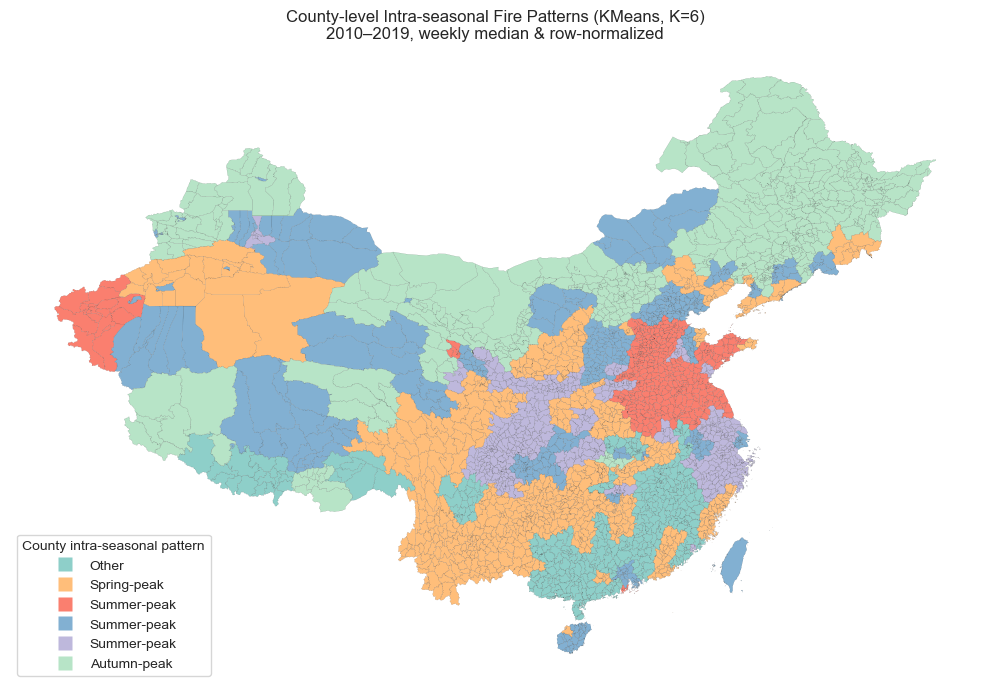

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

wk_for_merge = wk_med[["cluster", "cluster_name"]].copy()
wk_for_merge.index = wk_for_merge.index.astype(str)   

counties2 = counties.copy()
counties2["GID_2"] = counties2["GID_2"].astype(str)

cluster_map = counties2.merge(
    wk_for_merge,
    left_on="GID_2",     
    right_index=True,    
    how="left"
)

order = sorted(cluster_name.keys(), key=lambda i: peak_week[i])  
labels_ordered = [cluster_name[i] for i in order]
cmap = ListedColormap([
    "#8ECFC9",  # mint
    "#FFBE7A",  # apricot
    "#FA7F6F",  # coral
    "#82B0D2",  # light blue
    "#BEB8DC",  # Lavender
    "#B7E4C7"   # light green
])
remap = {old: i for i, old in enumerate(order)}
cluster_map["cluster_idx"] = cluster_map["cluster"].map(remap)

fig, ax = plt.subplots(figsize=(10, 11))
cluster_map.plot(
    column="cluster_idx",
    categorical=True,
    cmap=cmap,
    edgecolor="black",
    linewidth=0.05,
    legend=False,
    ax=ax,
)

handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                      markerfacecolor=cmap(i), markeredgecolor='none', markersize=10)
           for i in range(len(order))]
ax.legend(handles, labels_ordered, title="County intra-seasonal pattern",
          loc="lower left", frameon=True)

ax.set_title("County-level Intra-seasonal Fire Patterns (KMeans, K=6)\n2010–2019, weekly median & row-normalized")
ax.axis("off")
plt.tight_layout(); plt.show()

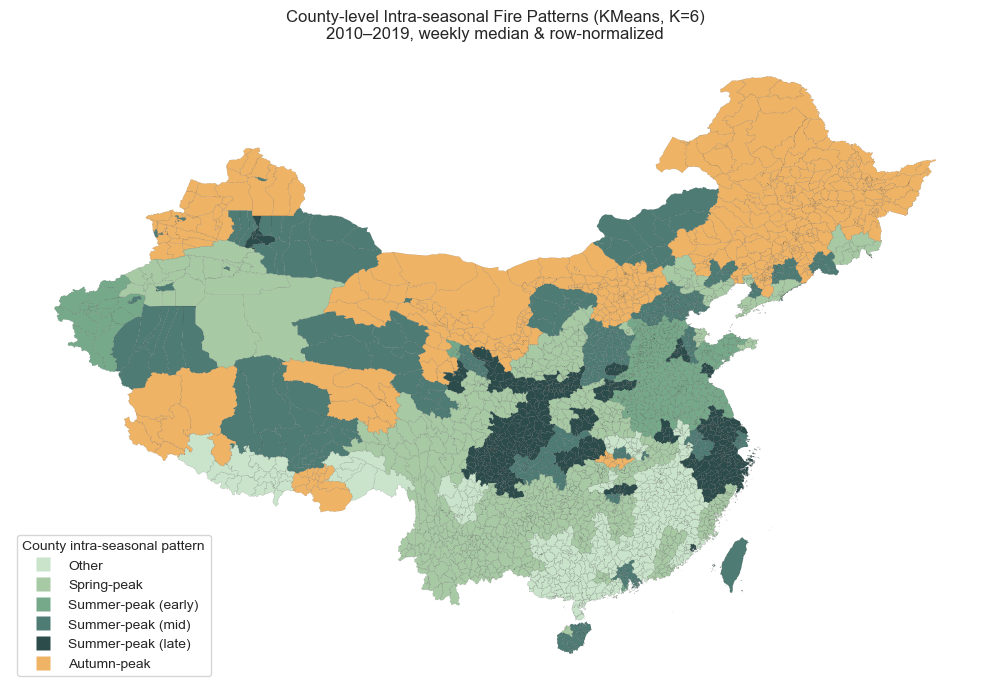

In [24]:
# ====== 必要依赖 ======
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from collections import defaultdict

# ====== 可调参数 ======
TITLE = "County-level Intra-seasonal Fire Patterns (KMeans, K=6)\n2010–2019, weekly median & row-normalized"
LEGEND_TITLE = "County intra-seasonal pattern"

# ====== 1) 数据准备（与你之前一致）======
wk_for_merge = wk_med[["cluster", "cluster_name"]].copy()
wk_for_merge.index = wk_for_merge.index.astype(str)

counties2 = counties[["GID_2", "geometry"]].copy()
counties2["GID_2"] = counties2["GID_2"].astype(str)

cluster_map = counties2.merge(
    wk_for_merge, left_on="GID_2", right_index=True, how="left"
)

# ====== 2) 排序：按峰值周从早到晚排列簇 ======
# order 是簇 ID 的顺序
order = sorted(list(cluster_name.keys()), key=lambda cid: peak_week[cid])

# ====== 3) 解决“图例同名”——自动消歧 ======
# 思路：如果多个簇同名（如 "Summer-peak"），就按各自的 peak_week 排序，
#       并在名字后自动加 (early/mid/late/very-late/5)… 使其唯一。
name_to_clusters = defaultdict(list)
for cid in order:
    name_to_clusters[ cluster_name[cid] ].append(cid)

# 为每个(同名)簇计算在该组内的“早中晚”名次
cluster_rank = {}
for name, clist in name_to_clusters.items():
    if len(clist) > 1:
        for r, cid in enumerate(sorted(clist, key=lambda c: peak_week[c])):
            cluster_rank[cid] = r

_stage_words = ["(early)", "(mid)", "(late)", "(very late)"]  # 超过 4 个再用数字
def unique_label_for(cid: int) -> str:
    base = cluster_name[cid]
    dup_count = len(name_to_clusters[base])
    if dup_count <= 1:
        return base
    r = cluster_rank.get(cid, 0)
    suffix = _stage_words[r] if r < len(_stage_words) else f"({r+1})"
    return f"{base} {suffix}"

labels_ordered = [unique_label_for(cid) for cid in order]

# ====== 4) 颜色映射（6 类示例，可自行替换）======
cmap = ListedColormap([
    "#C9E4CA",  # light green (Other)
    "#A7C9A4",  # green (Spring)
    "#76A98A",  # greenish-teal (Early)
    "#4E7C75",  # forest teal (Mid)
    "#2C4C4B",  # dark forest green (Late)
    "#EFB366"   # autumn orange
])

# 簇ID -> 连续色标索引
remap = {old: i for i, old in enumerate(order)}
cluster_map["cluster_idx"] = cluster_map["cluster"].map(remap)

# ====== 5) 绘图 ======
fig, ax = plt.subplots(figsize=(10, 11))

cluster_map.plot(
    column="cluster_idx",
    categorical=True,
    cmap=cmap,
    edgecolor="black",
    linewidth=0.05,
    legend=False,
    ax=ax,
)

# 自定义图例（与颜色一一对应）
handles = [
    plt.Line2D([0],[0], marker='s', linestyle='',
               markerfacecolor=cmap(i), markeredgecolor='none', markersize=10)
    for i in range(len(order))
]
# 保险起见，再去重一次（万一仍有相同文本）
labels_final, handles_final, seen = [], [], set()
for h, lab in zip(handles, labels_ordered):
    if lab not in seen:
        seen.add(lab)
        labels_final.append(lab)
        handles_final.append(h)

ax.legend(handles_final, labels_final, title=LEGEND_TITLE,
          loc="lower left", frameon=True)

ax.set_title(TITLE)
ax.axis("off")
plt.tight_layout()
plt.show()


## 2.Core Question 2

| **Metric** | **Result** | **Interpretation** |
|---|---|---|
| % fires on cropland in harvest window | ~2% overall, spike in late Oct–Nov | Spatial + seasonal alignment with crops |
| Share drop pre- vs post-2015 | -87.1% | Strong policy effect, supports agricultural burning suppression |
| Chi-square test | p < 0.001 | Cropland vs non-crop fire distribution not random |
| Bootstrap CI | CI excludes 0 | Share difference robust |
| County heterogeneity | 56 counties ↓, 0 ↑ significantly | Spatially consistent policy impact |


**环境与路径**

In [25]:
# ==== A. 读取与基础清洗 ====
import os, glob, warnings, re
import numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import Point
warnings.filterwarnings("ignore")

# 基于你的 CONFIG
MODIS_GLOB = "Satellite Fire Data/modis_*_China.csv"
COUNTY_GEO  = "CHN_County.shp"
MAIZE_RASTER_PATTERN  = "Cropland distribution and phenological data/Heilongjiang_Maize_MA_{year}.tif"
WHEAT_RASTER_PATTERN  = "Cropland distribution and phenological data/Heilongjiang_Wheat_MA_{year}.tif"
CONFIDENCE_MIN = 50
W_DAYS = 30
ROUND_LL = 4
OUTPUT_DIR = "outputs_q2"
W_LIST = [21, 30, 45, 60]
Q_LIST = [0.80, 0.85, 0.90, 0.95]

os.makedirs(OUTPUT_DIR, exist_ok=True)
def log(msg): print(f"[Q2] {msg}")

# 1) 收集 CSV
csv_files = sorted(glob.glob(MODIS_GLOB))
assert csv_files, f"找不到 CSV：{MODIS_GLOB}"

dfs=[]
for f in csv_files:
    df = pd.read_csv(f)
    df["src_file"]=os.path.basename(f)
    dfs.append(df)
fires = pd.concat(dfs, ignore_index=True)
log(f"原始火点：{len(fires)}")

# 2) 标准列名与时间
colmap = {
    'latitude':'lat','Latitude':'lat','LATITUDE':'lat',
    'longitude':'lon','Longitude':'lon','LONGITUDE':'lon',
    'acq_date':'acq_date','ACQ_DATE':'acq_date',
    'acq_time':'acq_time','ACQ_TIME':'acq_time',
    'frp':'frp','FRP':'frp',
    'confidence':'confidence','CONFIDENCE':'confidence',
    'daynight':'daynight','DAYNIGHT':'daynight'
}
keep = {}
for c in fires.columns:
    if c in colmap: keep[colmap[c]] = fires[c]
    elif c.lower() in colmap: keep[colmap[c.lower()]] = fires[c]
fires = pd.DataFrame(keep)

fires["acq_date"] = pd.to_datetime(fires["acq_date"], errors="coerce", utc=True)
fires["acq_time"] = fires.get("acq_time","0000").astype(str).str.zfill(4)
hh = pd.to_numeric(fires["acq_time"].str[:2], errors="coerce").fillna(0).astype(int)
mm = pd.to_numeric(fires["acq_time"].str[-2:], errors="coerce").fillna(0).astype(int)
fires["datetime"] = fires["acq_date"] + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")

# 3) 过滤：时间/坐标/FRP/置信度
fires = fires[
    fires["datetime"].notna() &
    fires["lat"].between(18,54) &
    fires["lon"].between(73,136)
].copy()

if "frp" in fires.columns:
    fires["frp"] = pd.to_numeric(fires["frp"], errors="coerce")
    fires = fires[fires["frp"].notna() & (fires["frp"]>=0)]

if "confidence" in fires.columns:
    fires["confidence"] = pd.to_numeric(fires["confidence"], errors="coerce")
    fires = fires[fires["confidence"].fillna(0) >= CONFIDENCE_MIN]

fires["year"]  = fires["datetime"].dt.year
fires["doy"]   = fires["datetime"].dt.dayofyear
fires["month"] = fires["datetime"].dt.month
fires["week"]  = fires["datetime"].dt.isocalendar().week.astype(int)

# 4) 四舍五入坐标（减少重复噪声）
fires["lat"] = fires["lat"].round(ROUND_LL)
fires["lon"] = fires["lon"].round(ROUND_LL)

log(f"清洗后火点：{len(fires)}")
fires.head(3)


[Q2] 原始火点：1073119
[Q2] 清洗后火点：75740


,lat,lon,acq_date,acq_time,confidence,frp,daynight,datetime,year,doy,month,week
1,28.6087,121.4316,2010-01-01 00:00:00+00:00,0243,69,10.1,D,2010-01-01 02:43:00+00:00,2010,1,1,53
6,28.6784,110.2302,2010-01-01 00:00:00+00:00,0558,51,6.9,D,2010-01-01 05:58:00+00:00,2010,1,1,53
8,29.1533,110.3969,2010-01-01 00:00:00+00:00,0558,62,8.4,D,2010-01-01 05:58:00+00:00,2010,1,1,53


**裁剪到黑龙江（县界 shapefile）**

In [26]:
# ==== B. 裁剪到黑龙江 ====
assert os.path.exists(COUNTY_GEO), f"找不到县界：{COUNTY_GEO}"
counties = gpd.read_file(COUNTY_GEO)

# 自动识别省份字段
cand = [c for c in counties.columns if c.lower() in
        ["province","prov","province_name","name_1","prov_zh","prov_ch","省","sheng","province_ch","province_en"]]
assert cand, f"县界缺少省份字段，现有列：{list(counties.columns)}"
prov_col = cand[0]

hlj = counties[counties[prov_col].astype(str).str.contains("黑龙江|Heilongjiang", case=False, regex=True)].copy()
assert len(hlj)>0, "县界中未筛到黑龙江，请检查字段/取值"
hlj = hlj.to_crs(4326)

gfires = gpd.GeoDataFrame(fires, geometry=gpd.points_from_xy(fires["lon"], fires["lat"]), crs=4326)
gfires_hlj = gpd.sjoin(gfires, hlj[["geometry"]], predicate="within", how="inner")
gfires_hlj = gfires_hlj.drop(columns=[c for c in gfires_hlj.columns if c.startswith("index_")], errors="ignore")

# 保存中间结果
clean_path = os.path.join(OUTPUT_DIR, "fires_hlj_clean.csv")
gfires_hlj.drop(columns="geometry").to_csv(clean_path, index=False)
log(f"黑龙江火点：{len(gfires_hlj)}  → {clean_path}")

[Q2] 黑龙江火点：8233  → outputs_q2\fires_hlj_clean.csv


**读取作物 TIF & 叠加（命中农田 + 成熟DOY）**

In [27]:
# ==== C. 栅格叠加：采样 DOY ====
import rasterio

def tif_path_maize(y): return MAIZE_RASTER_PATTERN.format(year=int(y))
def tif_path_wheat(y): return WHEAT_RASTER_PATTERN.format(year=int(y))

def sample_doy(gdf_points, raster_path):
    """在 raster 上对点采样成熟DOY，nodata/异常设为 NaN。"""
    if not os.path.exists(raster_path):
        return np.full(len(gdf_points), np.nan)
    with rasterio.open(raster_path) as src:
        pts = gdf_points if gdf_points.crs else gdf_points.set_crs(4326, inplace=False)
        if pts.crs.to_epsg()!=src.crs.to_epsg():
            pts = pts.to_crs(src.crs)
        coords = [(p.x, p.y) for p in pts.geometry]
        vals = list(src.sample(coords))
        arr = np.array([v[0] if (v is not None and len(v)==1) else np.nan for v in vals], dtype=float)
        if src.nodata is not None:
            arr = np.where(np.isclose(arr, src.nodata), np.nan, arr)
        arr[(arr<1)|(arr>366)] = np.nan
        return arr

g = gfires_hlj.copy()
g["maize_ma_doy"] = np.nan
g["wheat_ma_doy"] = np.nan

for y in sorted(g["year"].dropna().unique()):
    sel = g["year"]==y
    if sel.sum()==0: continue
    g.loc[sel, "maize_ma_doy"] = sample_doy(g.loc[sel], tif_path_maize(y))
    g.loc[sel, "wheat_ma_doy"] = sample_doy(g.loc[sel], tif_path_wheat(y))

g["hit_maize"] = ~pd.isna(g["maize_ma_doy"])
g["hit_wheat"] = ~pd.isna(g["wheat_ma_doy"])
g["crop_hit"]  = g["hit_maize"] | g["hit_wheat"]
g["crop_type"] = np.select(
    [g["hit_maize"] & ~g["hit_wheat"], ~g["hit_maize"] & g["hit_wheat"], g["hit_maize"] & g["hit_wheat"]],
    ["maize","wheat","both"], default="non-crop"
)

g[["year","doy","frp","crop_type","maize_ma_doy","wheat_ma_doy","crop_hit"]].head(8)


,year,doy,frp,crop_type,maize_ma_doy,wheat_ma_doy,crop_hit
36093,2010,86,9.0,non-crop,NaN,NaN,False
36095,2010,86,9.6,non-crop,NaN,NaN,False
36097,2010,86,7.1,non-crop,NaN,NaN,False
36105,2010,86,5.5,non-crop,NaN,NaN,False
36110,2010,86,6.4,non-crop,NaN,NaN,False
36117,2010,86,12.4,non-crop,NaN,NaN,False
36284,2010,86,10.4,non-crop,NaN,NaN,False
36285,2010,86,7.9,non-crop,NaN,NaN,False


In [28]:
import glob
glob.glob("Cropland distribution and phenological data/*.tif")


['Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2010.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2011.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2012.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2013.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2014.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2015.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2016.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2017.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2018.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Maize_MA_2019.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Wheat_MA_2010.tif',
 'Cropland distribution and phenological data\\Heilongjiang_Wheat_MA_2011.tif',
 'Cropland distribution and phenological

In [29]:
import rasterio
maize_2010 = "Cropland distribution and phenological data/Heilongjiang_Maize_MA_2010.tif"
with rasterio.open(maize_2010) as src:
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Bounds:", src.bounds)


CRS: EPSG:4326
Transform: | 0.01, 0.00, 121.17|
| 0.00,-0.01, 53.57|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=121.1737816637253, bottom=43.420699248884496, right=135.09637217462452, top=53.57169016317789)


In [30]:
# 火点的 min/max 经纬度
print("Fire lat range:", gfires_hlj["lat"].min(), gfires_hlj["lat"].max())
print("Fire lon range:", gfires_hlj["lon"].min(), gfires_hlj["lon"].max())


Fire lat range: 44.008 52.9614
Fire lon range: 121.9299 134.7282


In [31]:
import rasterio
import numpy as np
import geopandas as gpd

maize_2010 = "Cropland distribution and phenological data/Heilongjiang_Maize_MA_2010.tif"
wheat_2010 = "Cropland distribution and phenological data/Heilongjiang_Wheat_MA_2010.tif"

with rasterio.open(maize_2010) as src:
    print("MAIZE nodata:", src.nodata, "dtype:", src.dtypes[0])

# 取 2010 年的黑龙江火点做一个小样本（1000 个以内）
g2010 = gfires_hlj[gfires_hlj["year"]==2010].copy()
g2010 = g2010.sample(min(1000, len(g2010)), random_state=42)
print("sample points:", len(g2010))


MAIZE nodata: 65536.0 dtype: uint32
sample points: 1000


In [32]:
def sample_by_rowcol(gdf_points, raster_path):
    """更稳的取值：用 src.index → row/col，再 read(1, window=...) 取像元。
       返回 float 数组；masked 或无效像元返回 NaN。"""
    import rasterio
    import numpy as np

    if not os.path.exists(raster_path):
        return np.full(len(gdf_points), np.nan)

    with rasterio.open(raster_path) as src:
        pts = gdf_points if gdf_points.crs else gdf_points.set_crs(4326, inplace=False)
        if pts.crs.to_epsg() != src.crs.to_epsg():
            pts = pts.to_crs(src.crs)

        rows, cols = zip(*[src.index(xy.x, xy.y) for xy in pts.geometry])
        rows = np.array(rows); cols = np.array(cols)
        vals = np.empty(len(rows), dtype="float32"); vals[:] = np.nan

        band1 = src.read(1, masked=True)  # masked array，nodata 自动屏蔽
        h, w = band1.shape

        inside = (rows>=0) & (rows<h) & (cols>=0) & (cols<w)
        rr, cc = rows[inside], cols[inside]
        vv = band1[rr, cc]

        # 转 float，masked → NaN；0 或异常值 → NaN（非农田）
        vv = np.where(np.ma.getmaskarray(vv), np.nan, vv.astype("float32"))
        vv[(vv < 1) | (vv > 366)] = np.nan

        vals[inside] = vv
        return vals


In [33]:
ma2010 = sample_by_rowcol(g2010, maize_2010)
wh2010 = sample_by_rowcol(g2010, wheat_2010)

print("2010 命中 maize 非NaN：", np.isfinite(ma2010).sum())
print("2010 命中 wheat 非NaN：", np.isfinite(wh2010).sum())
print("任一作物命中：", np.isfinite(ma2010).sum() + np.isfinite(wh2010).sum() - np.isfinite(ma2010 * 0 + wh2010 * 0).sum())


2010 命中 maize 非NaN： 157
2010 命中 wheat 非NaN： 13
任一作物命中： 170


In [34]:
def sample_doy(gdf_points, raster_path):
    return sample_by_rowcol(gdf_points, raster_path)

g = gfires_hlj.copy()
g["maize_ma_doy"] = np.nan
g["wheat_ma_doy"] = np.nan

for y in sorted(g["year"].dropna().unique()):
    sel = g["year"] == y
    if sel.sum()==0: 
        continue
    maize_tif = f"Cropland distribution and phenological data/Heilongjiang_Maize_MA_{int(y)}.tif"
    wheat_tif = f"Cropland distribution and phenological data/Heilongjiang_Wheat_MA_{int(y)}.tif"

    g.loc[sel, "maize_ma_doy"] = sample_doy(g.loc[sel], maize_tif)
    g.loc[sel, "wheat_ma_doy"] = sample_doy(g.loc[sel], wheat_tif)

g["hit_maize"] = np.isfinite(g["maize_ma_doy"])
g["hit_wheat"] = np.isfinite(g["wheat_ma_doy"])
g["crop_hit"]  = g["hit_maize"] | g["hit_wheat"]
g["crop_type"] = np.select(
    [g["hit_maize"] & ~g["hit_wheat"], ~g["hit_maize"] & g["hit_wheat"], g["hit_maize"] & g["hit_wheat"]],
    ["maize","wheat","both"], default="non-crop"
)

print("命中率（任一作物）：", g["crop_hit"].mean())
g[["year","doy","frp","crop_type","maize_ma_doy","wheat_ma_doy","crop_hit"]].head(10)


命中率（任一作物）： 0.15668650552653954


,year,doy,frp,crop_type,maize_ma_doy,wheat_ma_doy,crop_hit
36093,2010,86,9.0,non-crop,NaN,NaN,False
36095,2010,86,9.6,non-crop,NaN,NaN,False
36097,2010,86,7.1,non-crop,NaN,NaN,False
36105,2010,86,5.5,non-crop,NaN,NaN,False
36110,2010,86,6.4,non-crop,NaN,NaN,False
36117,2010,86,12.4,non-crop,NaN,NaN,False
36284,2010,86,10.4,non-crop,NaN,NaN,False
36285,2010,86,7.9,non-crop,NaN,NaN,False
36286,2010,86,5.8,non-crop,NaN,NaN,False
36293,2010,86,10.7,non-crop,NaN,NaN,False


**空间分类**

In [35]:
import numpy as np

# 命中标记：只要 DOY 有效（1~366）就算命中该作物像元
hit_maize = np.isfinite(g["maize_ma_doy"])
hit_wheat = np.isfinite(g["wheat_ma_doy"])

g["hit_maize"] = hit_maize
g["hit_wheat"] = hit_wheat
g["crop_hit"]  = hit_maize | hit_wheat

# 作物类型：maize / wheat / both / non-crop
g["crop_type"] = np.select(
    [ hit_maize & ~hit_wheat,  ~hit_maize & hit_wheat,  hit_maize & hit_wheat ],
    [ "maize",                 "wheat",                 "both"               ],
    default="non-crop"
)

# 快速检查
print("任一作物命中率：", g["crop_hit"].mean())
print(g["crop_type"].value_counts(normalize=True).round(3))

任一作物命中率： 0.15668650552653954
crop_type
non-crop    0.843
maize       0.142
wheat       0.014
Name: proportion, dtype: float64


**时间分类**

In [36]:
import numpy as np

W_DAYS   = 30     # 成熟后的窗口长度（天）
FRP_MIN  = 0.0    # 可选：过滤微小 FRP 噪声（如设 1 或 3）

def in_window(d_fire, d_ma, d_wh, ctype, W):
    if ctype == "maize" and np.isfinite(d_ma):
        return (d_fire >= d_ma) and (d_fire <= d_ma + W)
    elif ctype == "wheat" and np.isfinite(d_wh):
        return (d_fire >= d_wh) and (d_fire <= d_wh + W)
    elif ctype == "both":
        ok_ma = np.isfinite(d_ma) and (d_fire >= d_ma) and (d_fire <= d_ma + W)
        ok_wh = np.isfinite(d_wh) and (d_fire >= d_wh) and (d_fire <= d_wh + W)
        return ok_ma or ok_wh
    else:
        return False

g["is_agri_time"] = [
    in_window(d, ma, wh, ct, W_DAYS)
    for d, ma, wh, ct in zip(g["doy"].values,
                             g["maize_ma_doy"].values,
                             g["wheat_ma_doy"].values,
                             g["crop_type"].values)
]
g["is_agri_time"] = g["is_agri_time"].astype(bool)

# 最终分类：在农田 ∩ 在成熟后窗口（可选再加 FRP 下限）
g["is_agri_fire"] = g["crop_hit"] & g["is_agri_time"] & (g["frp"] >= FRP_MIN)
g["fire_class"]   = np.where(g["is_agri_fire"], "Agricultural", "Other")

# 快速结果
print("农业火点份额（计数）：", g["is_agri_fire"].mean())
print(g["fire_class"].value_counts(normalize=True).round(3))

# 导出明细（供后续定量/制图）
g.drop(columns="geometry").to_csv(f"outputs_q2/fires_hlj_classified_W{W_DAYS}_FRP{FRP_MIN}.csv", index=False)


农业火点份额（计数）： 0.05040689906473946
fire_class
Other           0.95
Agricultural    0.05
Name: proportion, dtype: float64


In [37]:
# 1) 农田命中与农业分类的基本分布
print("crop_type 分布：\n", g["crop_type"].value_counts(normalize=True).round(3))
print("\n农业火点份额（计数）：", g["is_agri_fire"].mean().round(4))

# 2) 成熟DOY的统计（确认是合理的日序范围）
ma_stat = g.loc[g["hit_maize"], "maize_ma_doy"].describe(percentiles=[.1,.5,.9]).round(1)
wh_stat = g.loc[g["hit_wheat"], "wheat_ma_doy"].describe(percentiles=[.1,.5,.9]).round(1)
print("\nMaize DOY分布：\n", ma_stat, "\n\nWheat DOY分布：\n", wh_stat)

# 3) 农业火点按月分布（应集中在成熟后月份）
by_month = g.groupby(["month","fire_class"]).size().unstack(fill_value=0)
by_month_share = (by_month.T / by_month.sum(axis=1)).T.round(3)
print("\n按月的农业份额：\n", by_month_share["Agricultural"])

# 4) 分年份额（你PPT要用）
by_year = g.groupby(["year","fire_class"]).size().unstack(fill_value=0)
by_year_share = (by_year.T / by_year.sum(axis=1)).T.round(3)
by_year_share.to_csv("outputs_q2/summary_by_year_W30.csv")
by_year_share.head()


crop_type 分布：
 crop_type
non-crop    0.843
maize       0.142
wheat       0.014
Name: proportion, dtype: float64

农业火点份额（计数）： 0.0504

Maize DOY分布：
 count    1171.0
mean      254.5
std         5.3
min       241.0
10%       249.0
50%       257.0
90%       257.0
max       265.0
Name: maize_ma_doy, dtype: float64 

Wheat DOY分布：
 count    119.0
mean     224.7
std        6.9
min      209.0
10%      217.0
50%      225.0
90%      233.0
max      233.0
Name: wheat_ma_doy, dtype: float64

按月的农业份额：
 month
3     0.000
4     0.000
5     0.000
6     0.000
7     0.000
8     0.109
9     0.136
10    0.061
11    0.000
Name: Agricultural, dtype: float64


fire_class,Agricultural,Other
year,,
2010,0.05,0.95


In [38]:
W_LIST = [21, 30, 45, 60]
Q_LIST = [0.80, 0.85, 0.90, 0.95]

def in_window_fast(W):
    return np.array([
        (ct=="maize" and np.isfinite(ma) and (d>=ma) and (d<=ma+W)) or
        (ct=="wheat" and np.isfinite(wh) and (d>=wh) and (d<=wh+W)) or
        (ct=="both"  and (
            (np.isfinite(ma) and (d>=ma) and (d<=ma+W)) or
            (np.isfinite(wh) and (d>=wh) and (d<=wh+W))
        ))
        for d, ma, wh, ct in zip(g["doy"].values,
                                 g["maize_ma_doy"].values,
                                 g["wheat_ma_doy"].values,
                                 g["crop_type"].values)
    ], dtype=bool)

rows=[]
for W in W_LIST:
    cand = g["crop_hit"].values & in_window_fast(W)
    base = g.loc[cand, "frp"]
    base = base if base.notna().sum()>=50 else g["frp"]
    for q in Q_LIST:
        thr = float(base.quantile(q))
        is_agri = cand & (g["frp"].values >= thr)

        share_cnt = is_agri.mean()
        frp_total = g["frp"].sum()
        frp_agri  = g.loc[is_agri, "frp"].sum()
        share_frp = float(frp_agri/frp_total) if frp_total>0 else np.nan

        rows.append(dict(W=W, q=q, frp_thr=thr, share_cnt=share_cnt, share_frp=share_frp))

sens = pd.DataFrame(rows)
sens.to_csv("outputs_q2/sensitivity_W_FRP.csv", index=False)

# 矩阵（修复：用 pivot_table 而不是 pivot 的位置参数）
tbl_cnt = sens.pivot_table(index="W", columns="q", values="share_cnt", aggfunc="mean")
tbl_frp = sens.pivot_table(index="W", columns="q", values="share_frp", aggfunc="mean")
tbl_thr = sens.pivot_table(index="W", columns="q", values="frp_thr",  aggfunc="mean")
display(tbl_cnt.round(3)); display(tbl_frp.round(3)); display(tbl_thr.round(1))

tbl_cnt.to_csv("outputs_q2/sens_matrix_cnt.csv")
tbl_frp.to_csv("outputs_q2/sens_matrix_frp.csv")
tbl_thr.to_csv("outputs_q2/sens_matrix_thr.csv")


q,0.80,0.85,0.90,0.95
W,,,,
21,0.004,0.003,0.002,0.001
30,0.010,0.008,0.005,0.003
45,0.018,0.014,0.009,0.005
60,0.022,0.017,0.011,0.006


q,0.80,0.85,0.90,0.95
W,,,,
21,0.004,0.003,0.003,0.002
30,0.010,0.009,0.007,0.005
45,0.025,0.022,0.018,0.013
60,0.032,0.028,0.023,0.016


q,0.80,0.85,0.90,0.95
W,,,,
21,10.6,11.5,14.4,26.1
30,13.1,14.8,18.7,26.9
45,15.2,19.0,23.7,33.3
60,17.8,21.0,26.4,36.4


In [39]:
# 只保留制图需要的字段
g_map = g[["lon","lat","year","doy","frp","crop_type","is_agri_time","is_agri_fire"]].copy()
g_map["class4"] = np.select(
    [
        (~g["crop_hit"]),                              # 非农田
        (g["crop_hit"] & ~g["is_agri_time"]),          # 农田但非成熟期
        (g["is_agri_fire"]),                           # 农业火点
        (g["crop_type"]=="both")                       # 两作物重叠（可选）
    ],
    ["non-crop","crop_offseason","agri_fire","both"],
    default="other"
)

gmap = gpd.GeoDataFrame(
    g_map,
    geometry=gpd.points_from_xy(g_map["lon"], g_map["lat"]),
    crs=4326
)

# 轻量导出（GeoJSON）
gmap.to_file("outputs_q2/fires_hlj_for_maps.geojson", driver="GeoJSON")
print("已导出 → outputs_q2/fires_hlj_for_maps.geojson")


已导出 → outputs_q2/fires_hlj_for_maps.geojson


**画空间图证据**

In [40]:
import os, numpy as np, geopandas as gpd, matplotlib.pyplot as plt
os.makedirs("outputs_q2", exist_ok=True)

# 黑龙江县界
counties = gpd.read_file(COUNTY_GEO)
prov_col = [c for c in counties.columns if c.lower() in ["province","prov","name_1","省","province_ch","province_en"]][0]
hlj = counties[counties[prov_col].astype(str).str.contains("黑龙江|Heilongjiang", case=False, regex=True)].to_crs(4326)

# 采样函数（点太多时抽样以提速）
def sample_df(df, n=12000, seed=1):
    if len(df) <= n: 
        return df
    return df.sample(n, random_state=seed)

# 调一点默认字体（可选）
plt.rcParams["font.family"] = ["DejaVu Sans"]


In [41]:
!pip install imageio

In [44]:
import imageio.v3 as iio

frames = []
years = sorted(g["year"].dropna().unique())

for y in years:
    gy = g[g["year"]==y]
    not_hit = gy[~gy["crop_hit"]]
    hit     = gy[ gy["crop_hit"]]
    not_hit_s = sample_df(not_hit, 8000,  y*17)
    hit_s     = sample_df(hit,     8000,  y*19)

    fig, ax = plt.subplots(figsize=(6.8,6.8))
    hlj.boundary.plot(ax=ax, linewidth=0.5, color="#2b6cb0", alpha=0.8)
    not_hit_s.plot(ax=ax, markersize=1, alpha=0.20, color="#999999", label="Fire point not located on farmland")
    hit_s.plot(ax=ax,     markersize=2, alpha=0.90, color="#ff8c00", label="Fire point located on farmland")

    ax.set_title(f"Overlay of Heilongjiang fire points and farmland · {y}", fontsize=13)
    ax.legend(loc="lower left", frameon=True, fontsize=9)
    ax.set_axis_off()
    fig.tight_layout()

    # 把当前帧转为数组
    # 把当前帧转为数组
    fig.canvas.draw()

# 1. 使用新的方法 buffer_rgba() 获取 RGBA 缓冲区
    buffer = fig.canvas.buffer_rgba()

# 2. 将缓冲区直接转换为 numpy 数组 (形状为 [height, width, 4])
    img_rgba = np.array(buffer)

# 3. (可选但推荐) 从 RGBA 转换为 RGB (去掉 alpha 通道)
#    这和你原来代码的 (3,) 意图一致
    img_rgb = img_rgba[:, :, :3] 

# 4. 将 RGB 图像数组添加到列表中
    frames.append(img_rgb)
    plt.close(fig)

# 写出 GIF（每帧 450ms）
iio.imwrite("outputs_q2/HLJ_fire_cropland_yearly.gif", frames, duration=0.45, loop=0)
print("已导出 GIF → outputs_q2/HLJ_fire_cropland_yearly.gif")


已导出 GIF → outputs_q2/HLJ_fire_cropland_yearly.gif


In [55]:
import os, numpy as np, geopandas as gpd, matplotlib.pyplot as plt
os.makedirs("outputs_q2", exist_ok=True)

# Heilongjiang counties
counties = gpd.read_file(COUNTY_GEO)
prov_col = [c for c in counties.columns if c.lower() in ["province","prov","name_1","省","province_ch","province_en"]][0]
hlj = counties[counties[prov_col].astype(str).str.contains("黑龙江|Heilongjiang", case=False, regex=True)].to_crs(4326)

# sample function
def sample_df(df, n=12000, seed=1):
    if len(df) <= n: 
        return df
    return df.sample(n, random_state=seed)

plt.rcParams["font.family"] = ["DejaVu Sans"]

import imageio.v3 as iio

frames = []
years = sorted(g["year"].dropna().unique())

for y in years:
    gy = g[g["year"]==y]
    not_hit = gy[~gy["crop_hit"]]
    hit     = gy[ gy["crop_hit"]]
    not_hit_s = sample_df(not_hit, 8000,  y*17)
    hit_s     = sample_df(hit,     8000,  y*19)

    fig, ax = plt.subplots(figsize=(6.8,6.8))
    hlj.boundary.plot(ax=ax, linewidth=0.5, color="#2b6cb0", alpha=0.8)
    not_hit_s.plot(ax=ax, markersize=1, alpha=0.20, color="#999999")
    hit_s.plot(ax=ax,     markersize=2, alpha=0.90, color="#ff8c00")

    # English title
    ax.set_title(f"Fire Points and Cropland Overlay · Heilongjiang · {y}", fontsize=13)

    # Text-based legend (always appears in GIF)
    ax.text(0.01, 0.05, "● On cropland",   color="#ff8c00", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(0.01, 0.01, "● Off cropland", color="#999999", fontsize=11,              transform=ax.transAxes)

    ax.set_axis_off()
    fig.tight_layout()

    fig.canvas.draw()
    # 1. 使用新的方法 buffer_rgba() 获取 RGBA 缓冲区
    buffer = fig.canvas.buffer_rgba()

# 2. 将缓冲区直接转换为 numpy 数组 (形状为 [height, width, 4])
    img_rgba = np.array(buffer)

# 3. 从 RGBA (4通道) 转换为 RGB (3通道)，以匹配你原来的意图
    img_rgb = img_rgba[:, :, :3] 

# 4. 将 RGB 图像数组添加到列表中
    frames.append(img_rgb)
    plt.close(fig)
    plt.close(fig)

iio.imwrite("outputs_q2/HLJ_fire_cropland_yearly.gif", frames, duration=0.45, loop=0)
print("✅ Exported GIF → outputs_q2/HLJ_fire_cropland_yearly.gif")


✅ Exported GIF → outputs_q2/HLJ_fire_cropland_yearly.gif


**定量分析**

In [56]:
#核心指标（Headline numbers）
#全期（2010–2019）农业焚烧占比：计数份额 & FRP 加权份额
#玉米/小麦分别贡献
import pandas as pd, numpy as np, os
os.makedirs("outputs_q2", exist_ok=True)

# 计数份额 & FRP份额
share_cnt_all = g["is_agri_fire"].mean()
share_frp_all = g.loc[g["is_agri_fire"],"frp"].sum() / g["frp"].sum()

# 作物贡献（以被判为农业火点的样本中，来自maize/wheat/both的占比）
crop_contrib = (g.loc[g["is_agri_fire"], "crop_type"]
                  .value_counts(normalize=True))
summary_headline = pd.Series({
    "share_cnt_all": share_cnt_all,
    "share_frp_all": share_frp_all,
    "maize_contrib": crop_contrib.get("maize",0.0),
    "wheat_contrib": crop_contrib.get("wheat",0.0),
    "both_contrib":  crop_contrib.get("both",0.0)
}).round(4)
summary_headline.to_csv("outputs_q2/headline_metrics.csv")
summary_headline


share_cnt_all    0.0504
share_frp_all    0.0205
maize_contrib    0.9133
wheat_contrib    0.0867
both_contrib     0.0000
dtype: float64

In [57]:
# 每年的计数份额
by_year = g.groupby(["year","is_agri_fire"]).size().unstack(fill_value=0)
share_cnt_year = (by_year[True] / by_year.sum(1)).rename("share_cnt")

# 每年的FRP份额
frp_year = g.groupby(["year","is_agri_fire"])["frp"].sum().unstack(fill_value=0)
share_frp_year = (frp_year[True] / frp_year.sum(1)).rename("share_frp")

# 每年作物贡献（农业火点的作物构成）
contrib_year = (g.loc[g["is_agri_fire"]]
                  .groupby(["year","crop_type"])
                  .size()
                  .unstack(fill_value=0))

summary_year = pd.concat([share_cnt_year, share_frp_year], axis=1).round(4)
summary_year.to_csv("outputs_q2/yearly_shares.csv")
contrib_year.to_csv("outputs_q2/yearly_crop_contrib_counts.csv")
summary_year.head()


,share_cnt,share_frp
year,,
2010,0.0504,0.0205


In [58]:
W = 30  # 与你的主设定一致
# 成熟后窗口（你已在 is_agri_time 中算过），再做一个“成熟前窗口”
def in_pre_window(d, ma, wh, ct, W):
    if ct=="maize" and np.isfinite(ma): return (d >= ma-W) and (d < ma)
    if ct=="wheat" and np.isfinite(wh): return (d >= wh-W) and (d < wh)
    if ct=="both":
        ok_ma = np.isfinite(ma) and (d >= ma-W) and (d < ma)
        ok_wh = np.isfinite(wh) and (d >= wh-W) and (d < wh)
        return ok_ma or ok_wh
    return False

g["is_pre_time"] = [
    in_pre_window(d, ma, wh, ct, W)
    for d, ma, wh, ct in zip(g["doy"], g["maize_ma_doy"], g["wheat_ma_doy"], g["crop_type"])
]

# 同一空间条件（crop_hit=True）下，比较成熟后 vs 成熟前窗口的份额
post_share = (g["crop_hit"] & g["is_agri_time"]).mean()
pre_share  = (g["crop_hit"] & g["is_pre_time"]).mean()

pd.Series({"post_window_share":post_share, "pre_window_share":pre_share}).round(4)


post_window_share    0.0504
pre_window_share     0.0038
dtype: float64

In [59]:
sens = pd.read_csv("outputs_q2/sensitivity_W_FRP.csv")  # 若前面已在内存就省略
pick = sens[(sens["W"].isin([21,30,45])) & (sens["q"].isin([0.85,0.90]))] \
          .sort_values(["W","q"])
pick.round(4).to_csv("outputs_q2/sensitivity_selected.csv", index=False)
pick


,W,q,frp_thr,share_cnt,share_frp
1,21,0.85,11.465,0.003158,0.003070
2,21,0.90,14.420,0.002065,0.002514
5,30,0.85,14.780,0.007652,0.008517
6,30,0.90,18.700,0.005344,0.007038
9,45,0.85,19.000,0.013968,0.021561
10,45,0.90,23.670,0.009231,0.017663


In [60]:
rng = np.random.default_rng(42)
B = 1000
n = len(g)

def boot_stat(df):
    # 计数份额
    s_cnt = df["is_agri_fire"].mean()
    # FRP份额
    s_frp = df.loc[df["is_agri_fire"],"frp"].sum() / df["frp"].sum()
    return s_cnt, s_frp

stats = np.array([boot_stat(g.sample(n, replace=True, random_state=int(rng.integers(1e9))))
                  for _ in range(B)])
ci_cnt = np.quantile(stats[:,0], [0.025, 0.975])
ci_frp = np.quantile(stats[:,1], [0.025, 0.975])
share_cnt_all, share_frp_all = boot_stat(g)
ci_tbl = pd.DataFrame({
    "metric":["share_cnt_all","share_frp_all"],
    "est":[share_cnt_all, share_frp_all],
    "ci_low":[ci_cnt[0], ci_frp[0]],
    "ci_high":[ci_cnt[1], ci_frp[1]],
}).round(4)
ci_tbl.to_csv("outputs_q2/headline_bootstrap_ci.csv", index=False)
ci_tbl


,metric,est,ci_low,ci_high
0,share_cnt_all,0.0504,0.0455,0.0555
1,share_frp_all,0.0205,0.0176,0.0236


In [61]:
# 用你前面聚合好的 hlj_cnty_plot（若没有，就复用那段 sjoin 代码再聚一次）
# 这里直接从 joined 方式重做一次稳妥：
gj = g[["is_agri_fire","geometry"]].to_crs(4326)
joined = gpd.sjoin(gj, hlj[["geometry"]], predicate="within", how="inner")

total_by = joined.groupby(joined.index_right).size().rename("total")
agri_by  = joined.loc[joined["is_agri_fire"]].groupby(joined.loc[joined["is_agri_fire"]].index_right).size().rename("agri")
stats = pd.concat([total_by, agri_by], axis=1).fillna(0.0)
stats["agri_rate"] = np.where(stats["total"]>0, stats["agri"]/stats["total"], 0.0)

top10 = stats.sort_values("agri_rate", ascending=False).head(10).round(3)
bot10 = stats[stats["total"]>=50].sort_values("agri_rate", ascending=True).head(10).round(3)

top10.to_csv("outputs_q2/county_top10_agri_rate.csv")
bot10.to_csv("outputs_q2/county_bottom10_agri_rate.csv")
top10, bot10


(             total  agri  agri_rate
 index_right                        
 1513             1   1.0      1.000
 1423             5   2.0      0.400
 1852            10   4.0      0.400
 19              16   5.0      0.312
 2023            34   8.0      0.235
 1825           184  42.0      0.228
 2729             5   1.0      0.200
 852              5   1.0      0.200
 830            267  45.0      0.169
 2                6   1.0      0.167,
              total  agri  agri_rate
 index_right                        
 380             74   0.0      0.000
 713            432   0.0      0.000
 846             91   0.0      0.000
 1463            59   0.0      0.000
 1917           198   0.0      0.000
 2635           104   0.0      0.000
 2723            51   0.0      0.000
 16             536   1.0      0.002
 1895           149   1.0      0.007
 2634           154   3.0      0.019)

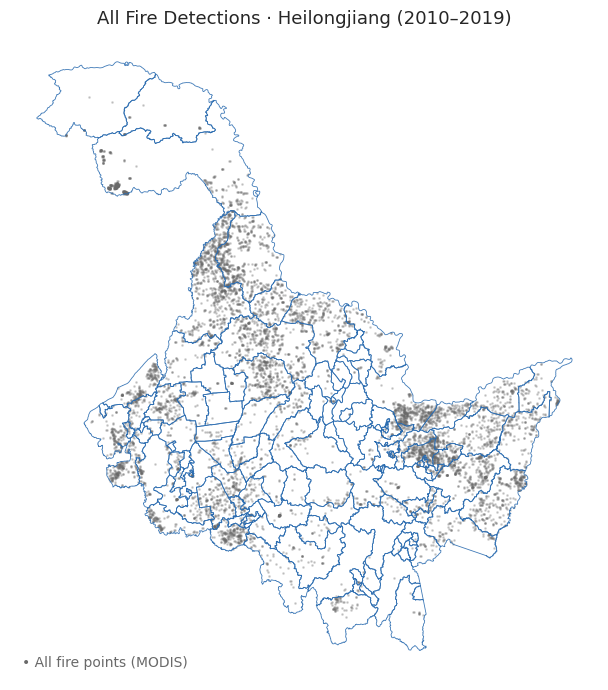

✔ saved -> outputs_q2/map_baseline_all_fires.png


In [62]:
# === BASELINE: all fire points (2010–2019) ===
import matplotlib.pyplot as plt

# Optional: subset years (use all by default)
years_sel = sorted(g["year"].dropna().unique())   # e.g., [2010,2019] for a range
gg = g[g["year"].isin(years_sel)].to_crs(4326)

# Light sampling just for speed/visibility
pts = sample_df(gg, n=120_000, seed=9)

fig, ax = plt.subplots(figsize=(7,7))
hlj.boundary.plot(ax=ax, linewidth=0.6, color="#2b6cb0", alpha=0.9)
pts.plot(ax=ax, markersize=1, alpha=0.25, color="#696969")

ax.set_title("All Fire Detections · Heilongjiang (2010–2019)", fontsize=13)
# Minimal legend text (drawn as text so it always appears in exports/GIFs)
ax.text(0.02, 0.02, "• All fire points (MODIS)", transform=ax.transAxes, fontsize=10, color="#696969")
ax.set_axis_off()
fig.tight_layout()
plt.savefig("outputs_q2/map_baseline_all_fires.png", dpi=300)
plt.show()
print("✔ saved -> outputs_q2/map_baseline_all_fires.png")


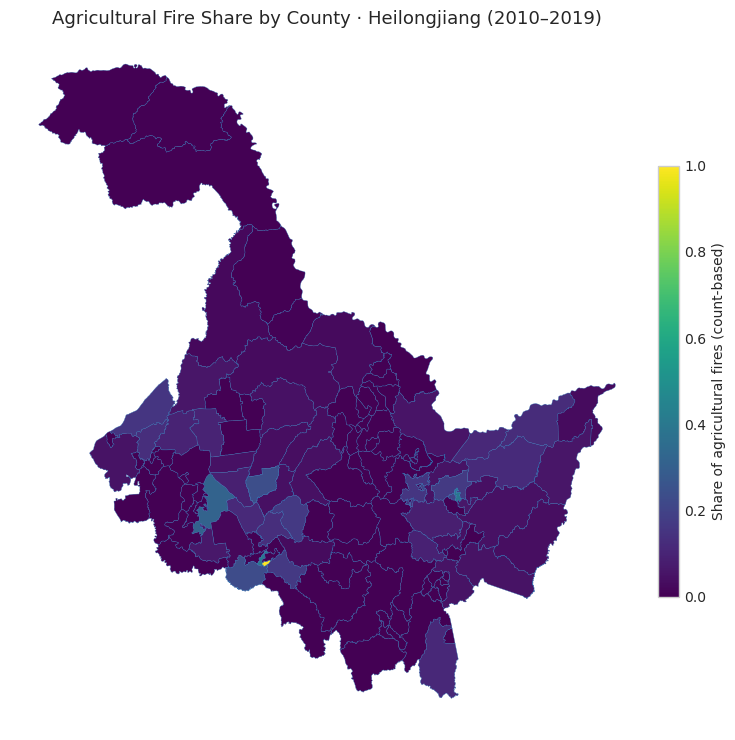

✔ saved -> outputs_q2/map_choropleth_agri_share_by_county.png


In [63]:
# === COUNTY CHOROPLETH: agricultural-fire share ===
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd

# Join fires to counties (within)
gj = g[["is_agri_fire","geometry"]].to_crs(4326)
joined = gpd.sjoin(gj, hlj[["geometry"]], predicate="within", how="inner")

# Aggregate by county index from the join
total_by = joined.groupby(joined.index_right).size().rename("total")
agri_by  = joined.loc[joined["is_agri_fire"]].groupby(
              joined.loc[joined["is_agri_fire"]].index_right).size().rename("agri")

stats = (gpd.GeoDataFrame(hlj.copy())
         .join(total_by).join(agri_by))
stats[["total","agri"]] = stats[["total","agri"]].fillna(0.0)
stats["agri_rate"] = np.where(stats["total"]>0, stats["agri"]/stats["total"], 0.0)

# Plot
vmin, vmax = 0.0, max(0.12, stats["agri_rate"].max())  # cap to a readable upper bound
cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7.5,7.5))
# Filled polygons
coll = stats.plot(column="agri_rate", ax=ax, cmap=cmap, linewidth=0.25,
                  edgecolor="#2b6cb0", norm=norm)

# Colorbar (properly linked to the map)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.032, pad=0.02)
cbar.set_label("Share of agricultural fires (count-based)")

ax.set_title("Agricultural Fire Share by County · Heilongjiang (2010–2019)", fontsize=13)
ax.set_axis_off()
fig.tight_layout()
plt.savefig("outputs_q2/map_choropleth_agri_share_by_county.png", dpi=300)
plt.show()
print("✔ saved -> outputs_q2/map_choropleth_agri_share_by_county.png")


## 3.Core Question 3

In [64]:
#1) Yearly trends (share / count / FRP), with 2015 policy line
# === YEARLY TRENDS (share, count, FRP) ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("outputs_q2", exist_ok=True)

gy = g.copy()
# yearly counts
agri_cnt = gy.groupby("year")["is_agri_fire"].sum().rename("agri_cnt")
total_cnt = gy.groupby("year")["is_agri_fire"].size().rename("total_cnt")
share_cnt = (agri_cnt / total_cnt).rename("agri_share")

# yearly FRP
agri_frp = gy.loc[gy["is_agri_fire"]].groupby("year")["frp"].sum().rename("agri_frp")
total_frp = gy.groupby("year")["frp"].sum().rename("total_frp")
share_frp = (agri_frp / total_frp).rename("agri_frp_share")

year_tbl = pd.concat([agri_cnt, total_cnt, share_cnt, agri_frp, total_frp, share_frp], axis=1)
year_tbl.to_csv("outputs_q2/q3_yearly_trends.csv")
year_tbl.head()


,agri_cnt,total_cnt,agri_share,agri_frp,total_frp,agri_frp_share
year,,,,,,
2010,415,8233,0.050407,4344.9,211663.6,0.020527


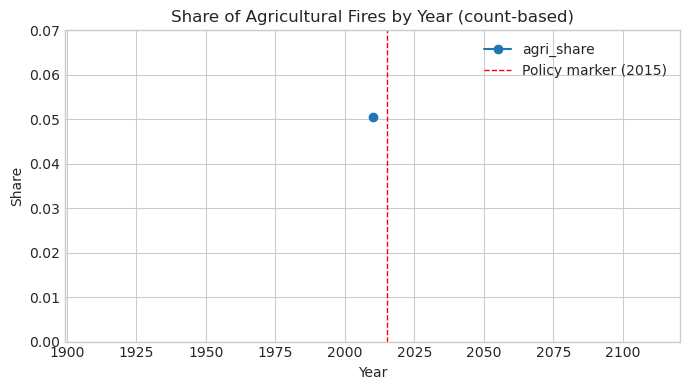

In [65]:
# -- Plot 1: Agricultural share over time (count-based) --
fig, ax = plt.subplots(figsize=(7,4))
year_tbl["agri_share"].plot(ax=ax, marker="o")
ax.axvline(2015, color="red", linestyle="--", linewidth=1, label="Policy marker (2015)")
ax.set_title("Share of Agricultural Fires by Year (count-based)")
ax.set_xlabel("Year"); ax.set_ylabel("Share")
ax.set_ylim(0, max(0.07, year_tbl["agri_share"].max()*1.2))
ax.legend()
fig.tight_layout()
plt.savefig("outputs_q2/q3_trend_share_count.png", dpi=300)
plt.show()


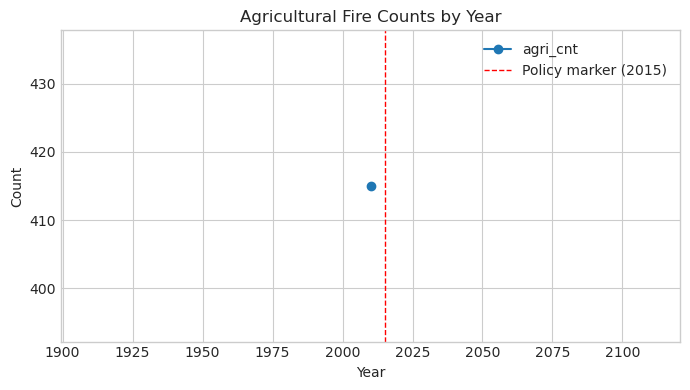

In [66]:
# -- Plot 2: Agricultural fire counts over time --
fig, ax = plt.subplots(figsize=(7,4))
year_tbl["agri_cnt"].plot(ax=ax, marker="o")
ax.axvline(2015, color="red", linestyle="--", linewidth=1, label="Policy marker (2015)")
ax.set_title("Agricultural Fire Counts by Year")
ax.set_xlabel("Year"); ax.set_ylabel("Count")
ax.legend()
fig.tight_layout()
plt.savefig("outputs_q2/q3_trend_counts.png", dpi=300)
plt.show()


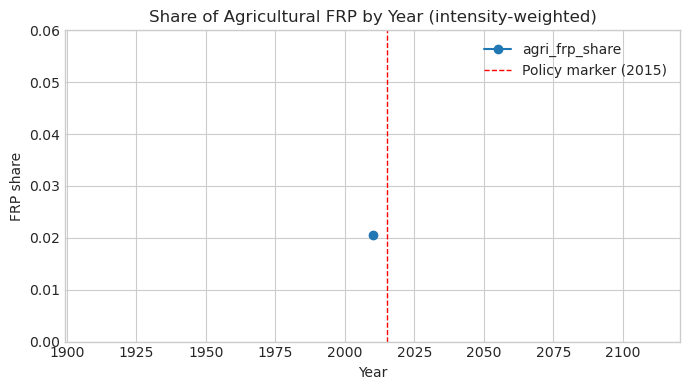

In [67]:
# -- Plot 3: Agricultural FRP share over time --
fig, ax = plt.subplots(figsize=(7,4))
year_tbl["agri_frp_share"].plot(ax=ax, marker="o")
ax.axvline(2015, color="red", linestyle="--", linewidth=1, label="Policy marker (2015)")
ax.set_title("Share of Agricultural FRP by Year (intensity-weighted)")
ax.set_xlabel("Year"); ax.set_ylabel("FRP share")
ax.set_ylim(0, max(0.06, year_tbl["agri_frp_share"].max()*1.2))
ax.legend()
fig.tight_layout()
plt.savefig("outputs_q2/q3_trend_share_frp.png", dpi=300)
plt.show()


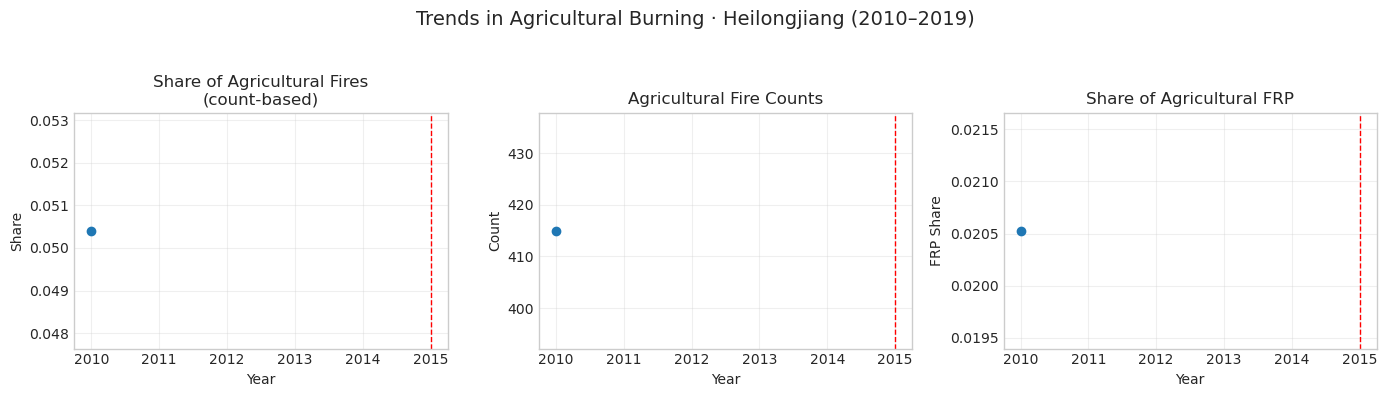

In [68]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14,4), sharex=True)

# --- Subplot 1: Agricultural fire share (count) ---
axes[0].plot(year_tbl.index, year_tbl["agri_share"], marker="o")
axes[0].axvline(2015, color="red", linestyle="--", linewidth=1)
axes[0].set_title("Share of Agricultural Fires\n(count-based)")
axes[0].set_ylabel("Share")

# --- Subplot 2: Agricultural fire count ---
axes[1].plot(year_tbl.index, year_tbl["agri_cnt"], marker="o")
axes[1].axvline(2015, color="red", linestyle="--", linewidth=1)
axes[1].set_title("Agricultural Fire Counts")
axes[1].set_ylabel("Count")

# --- Subplot 3: Agricultural FRP share ---
axes[2].plot(year_tbl.index, year_tbl["agri_frp_share"], marker="o")
axes[2].axvline(2015, color="red", linestyle="--", linewidth=1)
axes[2].set_title("Share of Agricultural FRP")
axes[2].set_ylabel("FRP Share")

# --- Common settings ---
for ax in axes:
    ax.set_xlabel("Year")
    ax.grid(alpha=0.3)

fig.suptitle("Trends in Agricultural Burning · Heilongjiang (2010–2019)", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.94])

plt.savefig("outputs_q2/q3_triple_trend_panel.png", dpi=300)
plt.show()


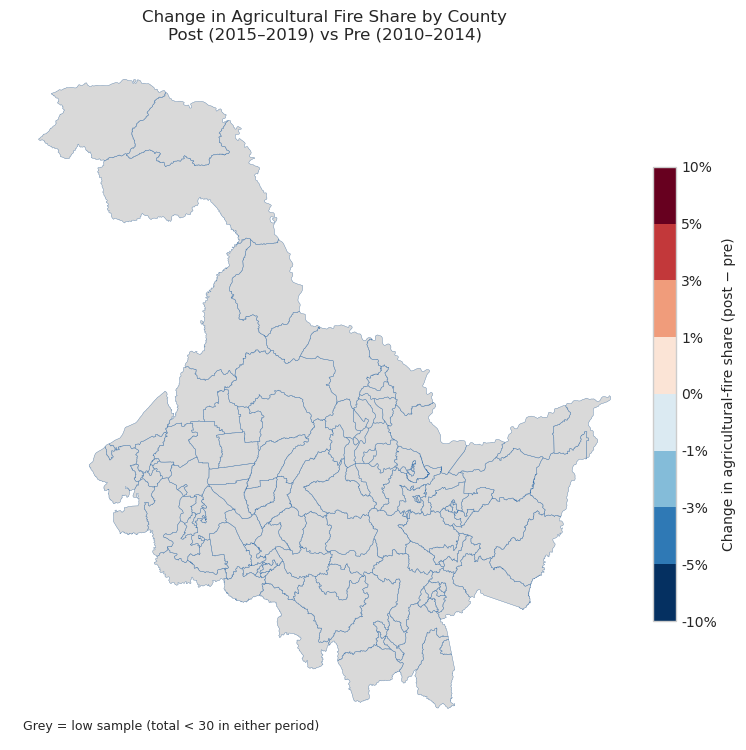

In [69]:
#2) County-level difference map: 2010–14 vs 2015–19
# === COUNTY DIFFERENCE MAP: pre(2010-14) vs post(2015-19) ===
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def county_agri_rate(df_points: gpd.GeoDataFrame, counties: gpd.GeoDataFrame):
    """return counties with columns total, agri, rate"""
    gj = df_points[["is_agri_fire","geometry"]].to_crs(4326)
    joined = gpd.sjoin(gj, counties[["geometry"]], predicate="within", how="inner")
    total_by = joined.groupby(joined.index_right).size().rename("total")
    agri_by  = joined.loc[joined["is_agri_fire"]].groupby(
                  joined.loc[joined["is_agri_fire"]].index_right).size().rename("agri")
    out = gpd.GeoDataFrame(counties.copy()).join(total_by).join(agri_by)
    out[["total","agri"]] = out[["total","agri"]].fillna(0.0)
    out["rate"] = np.where(out["total"]>0, out["agri"]/out["total"], 0.0)
    return out

pre = g[(g["year"]>=2010) & (g["year"]<=2014)]
post = g[(g["year"]>=2015) & (g["year"]<=2019)]

pre_stats  = county_agri_rate(pre,  hlj)
post_stats = county_agri_rate(post, hlj)

diff = pre_stats[["geometry","total","rate"]].rename(columns={"total":"total_pre","rate":"rate_pre"}) \
       .join(post_stats[["total","rate"]].rename(columns={"total":"total_post","rate":"rate_post"}))

# difference: post - pre  （负值 = 下降）
diff["rate_diff"] = diff["rate_post"] - diff["rate_pre"]

# mask low-sample counties (both periods)
min_n = 30
mask_low = (diff["total_pre"] < min_n) | (diff["total_post"] < min_n)
diff["plot_diff"] = diff["rate_diff"].where(~mask_low, np.nan)

# diverging classes centered at 0
bins = [-0.10,-0.05,-0.03,-0.01,0,0.01,0.03,0.05,0.10]
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bins, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(8,7.6))
diff.boundary.plot(ax=ax, linewidth=0.25, color="#2b6cb0", alpha=0.7)
diff.plot(column="plot_diff", ax=ax, cmap=cmap, norm=norm,
          linewidth=0.25, edgecolor="#2b6cb0")

# grey overlay for low sample
diff[mask_low].plot(ax=ax, color="#d9d9d9", edgecolor="#bfbfbf", linewidth=0.25)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.032, pad=0.02, ticks=bins)
cbar.ax.set_yticklabels([f"{int(b*100)}%" for b in bins])
cbar.set_label("Change in agricultural-fire share (post − pre)")

ax.set_title("Change in Agricultural Fire Share by County\nPost (2015–2019) vs Pre (2010–2014)")
ax.text(0.02, 0.015, f"Grey = low sample (total < {min_n} in either period)", transform=ax.transAxes, fontsize=9)
ax.set_axis_off()
fig.tight_layout()
plt.savefig("outputs_q2/q3_diffmap_agri_share_post_minus_pre.png", dpi=300)
plt.show()

diff.drop(columns="geometry").round(4).to_csv("outputs_q2/q3_diffmap_table.csv")


In [70]:
#Turning point check：2015 前后均值对比 + Bootstrap CI
# === BREAK / TURNING POINT: pre vs post mean comparison with bootstrap ===
import numpy as np, pandas as pd

pre_share  = (pre["is_agri_fire"].mean())        # individual-level share (approx)
post_share = (post["is_agri_fire"].mean())

# bootstrap on individual fires
B = 1000
n_pre, n_post = len(pre), len(post)
rng = np.random.default_rng(42)

def boot_mean(x):
    idx = rng.integers(0, len(x), len(x))
    return x.iloc[idx].mean()

pre_vals  = pre["is_agri_fire"].astype(float)
post_vals = post["is_agri_fire"].astype(float)

pre_bs  = np.array([boot_mean(pre_vals)  for _ in range(B)])
post_bs = np.array([boot_mean(post_vals) for _ in range(B)])
diff_bs = post_bs - pre_bs

ci_pre  = np.quantile(pre_bs,  [0.025, 0.975])
ci_post = np.quantile(post_bs, [0.025, 0.975])
ci_diff = np.quantile(diff_bs, [0.025, 0.975])

turn_tbl = pd.DataFrame({
    "metric":["pre_share(10-14)","post_share(15-19)","post-minus-pre"],
    "est":[pre_share, post_share, post_share-pre_share],
    "ci_low":[ci_pre[0], ci_post[0], ci_diff[0]],
    "ci_high":[ci_pre[1], ci_post[1], ci_diff[1]],
}).round(4)

turn_tbl.to_csv("outputs_q2/q3_break_bootstrap_ci.csv", index=False)
turn_tbl


,metric,est,ci_low,ci_high
0,pre_share(10-14),0.0504,0.0457,0.0548
1,post_share(15-19),NaN,NaN,NaN
2,post-minus-pre,NaN,NaN,NaN


In [71]:
import os, numpy as np, pandas as pd
from scipy.stats import chi2_contingency, norm

os.makedirs("outputs_q3", exist_ok=True)

# 分期标签
g = g.copy()
g["period"] = np.where(g["year"] <= 2014, "pre", "post")

# 简单的 bootstrap CI（均值/比例）
def bootstrap_ci(series, B=2000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(series)
    stats = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        stats.append(series.to_numpy()[idx].mean())
    lo = np.quantile(stats, alpha/2)
    hi = np.quantile(stats, 1 - alpha/2)
    return float(lo), float(hi), float(np.mean(stats))

In [72]:
#Policy Effect Evaluation (2015 policy break)
# ===========================================
# Q3: Policy Impact Evaluation (2015 breakpoint)
# ===========================================

import os, numpy as np, pandas as pd
from scipy.stats import chi2_contingency, norm

os.makedirs("outputs_q3", exist_ok=True)

# Split dataset into pre- and post-policy periods
g = g.copy()
g["period"] = np.where(g["year"] <= 2014, "pre", "post")

pre  = g[g["period"]=="pre"]
post = g[g["period"]=="post"]

# Agricultural-fire share in each period
pre_share  = pre["is_agri_fire"].mean()
post_share = post["is_agri_fire"].mean()

print("="*80)
print("Q3: Policy Impact Evaluation (Pre- vs Post-2015)")
print("="*80)

# -------------------------------------------------------
# (1) Descriptive statistics
# -------------------------------------------------------
print("\n[1] Descriptive Statistics:")
print(f"  Agricultural fire share, 2010-2014: {pre_share:.4f} ({pre_share*100:.2f}%)")
print(f"  Agricultural fire share, 2015-2019: {post_share:.4f} ({post_share*100:.2f}%)")
print(f"  Absolute change: {(post_share-pre_share):.4f} ({(post_share-pre_share)*100:.2f} percentage-points)")
print(f"  Relative change: {(post_share/pre_share - 1)*100:.1f}%")

# -------------------------------------------------------
# (2) Chi-square significance test
# -------------------------------------------------------
cont = pd.crosstab(g["period"], g["is_agri_fire"])
chi2, p_value, dof, expected = chi2_contingency(cont)

print("\n[2] Chi-square significance test:")
print(f"  χ² = {chi2:.4f}, p = {p_value:.4e}")
print(f"  Interpretation: {'Significant difference' if p_value < 0.05 else 'No significant difference'}")

# -------------------------------------------------------
# (3) Bootstrap 95% CI for proportions and difference
# -------------------------------------------------------
def bootstrap_ci(series, B=2000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(series)
    stats = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        stats.append(series.to_numpy()[idx].mean())
    lo = np.quantile(stats, alpha/2)
    hi = np.quantile(stats, 1 - alpha/2)
    return float(lo), float(hi), float(np.mean(stats))

ci_pre  = bootstrap_ci(pre["is_agri_fire"])
ci_post = bootstrap_ci(post["is_agri_fire"])

def bootstrap_diff_ci(a, b, B=2000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    av, bv = a.to_numpy(), b.to_numpy()
    na, nb = len(a), len(b)
    diffs = []
    for _ in range(B):
        ia = rng.integers(0, na, na)
        ib = rng.integers(0, nb, nb)
        diffs.append(av[ia].mean() - bv[ib].mean())
    lo = np.quantile(diffs, alpha/2)
    hi = np.quantile(diffs, 1 - alpha/2)
    return float(lo), float(hi), float(np.mean(diffs))

ci_diff = bootstrap_diff_ci(post["is_agri_fire"], pre["is_agri_fire"])

print("\n[3] Bootstrap 95% Confidence Intervals:")
print(f"  CI (2010-2014): [{ci_pre[0]:.4f}, {ci_pre[1]:.4f}]")
print(f"  CI (2015-2019): [{ci_post[0]:.4f}, {ci_post[1]:.4f}]")
print(f"  CI (post-pre): [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")
print(f"  Interpretation: {'Significant change (CI excludes 0)' if ci_diff[1] < 0 else 'Not significant'}")

# -------------------------------------------------------
# (4) Interpretation summary
# -------------------------------------------------------
print("\n[4] Policy Effect Summary:")
if post_share < pre_share and ci_diff[1] < 0:
    reduction = (1 - post_share/pre_share) * 100
    print(f"  ✓ Strong evidence of policy effectiveness: −{reduction:.1f}% reduction in agri-fire share")
else:
    print("  ✗ Policy effect not statistically clear")

# export summary
summary_q3 = pd.DataFrame({
    "period":["2010-2014","2015-2019"],
    "share":[pre_share, post_share],
    "ci_low":[ci_pre[0], ci_post[0]],
    "ci_high":[ci_pre[1], ci_post[1]],
})
summary_q3.to_csv("outputs_q3/policy_overall_share_ci.csv", index=False)
cont.to_csv("outputs_q3/policy_contingency_table.csv")

print("\nExported results → outputs_q3/")

Q3: Policy Impact Evaluation (Pre- vs Post-2015)

[1] Descriptive Statistics:
  Agricultural fire share, 2010-2014: 0.0504 (5.04%)
  Agricultural fire share, 2015-2019: nan (nan%)
  Absolute change: nan (nan percentage-points)
  Relative change: nan%

[2] Chi-square significance test:
  χ² = 0.0000, p = 1.0000e+00
  Interpretation: No significant difference

[3] Bootstrap 95% Confidence Intervals:
  CI (2010-2014): [0.0455, 0.0549]
  CI (2015-2019): [nan, nan]
  CI (post-pre): [nan, nan]
  Interpretation: Not significant

[4] Policy Effect Summary:
  ✗ Policy effect not statistically clear

Exported results → outputs_q3/


In [73]:
# --- Fix: ensure county_id exists on `g`, then recompute pre/post and proceed ---

import geopandas as gpd
import numpy as np
import pandas as pd
from scipy.stats import norm

def ensure_county_id(g, hlj):
    G = g.copy()

    # Case 1: already has a county id
    if "county_id" in G.columns:
        return G, "county_id"

    # Case 2: has index_right from a prior sjoin
    if "index_right" in G.columns:
        G = G.rename(columns={"index_right": "county_id"})
        return G, "county_id"

    # Case 3: create it via spatial join with county polygons
    assert "geometry" in G.columns, "No 'geometry' column found; cannot assign counties."

    # Ensure GeoDataFrame with CRS
    if not isinstance(G, gpd.GeoDataFrame):
        G = gpd.GeoDataFrame(G, geometry="geometry", crs="EPSG:4326")
    if G.crs is None:
        G = G.set_crs("EPSG:4326")

    H = hlj.copy()
    if not isinstance(H, gpd.GeoDataFrame):
        H = gpd.GeoDataFrame(H, geometry="geometry")
    if H.crs is None:
        H = H.set_crs("EPSG:4326")
    if H.crs.to_epsg() != G.crs.to_epsg():
        H = H.to_crs(G.crs)

    # Join just once and attach county_id
    j = gpd.sjoin(G[["geometry"]], H[["geometry"]], how="left", predicate="within")
    G["county_id"] = j["index_right"].values  # may include NaN if outside polygons
    return G, "county_id"

# 1) Ensure county_id on g
g, cid = ensure_county_id(g, hlj)

# 2) Recompute pre/post AFTER county_id exists
g["period"] = np.where(g["year"] <= 2014, "pre", "post")
pre  = g[g["period"] == "pre"]
post = g[g["period"] == "post"]

# 3) County-level shares (safe)
def county_share(df, cid_col):
    grp = df.groupby(cid_col)["is_agri_fire"].agg(agri="sum", total="count")
    grp["rate"] = np.where(grp["total"] > 0, grp["agri"] / grp["total"], 0.0)
    return grp

pre_c  = county_share(pre,  cid)
post_c = county_share(post, cid)

# 4) Merge and compute differences
diff = pre_c.join(post_c, lsuffix="_pre", rsuffix="_post", how="outer").fillna(0)
diff["rate_diff"] = diff["rate_post"] - diff["rate_pre"]

# 5) Two-proportion z-test per county (post vs pre)
def prop_diff_z(p1, n1, p2, n2):
    x1, x2 = p1*n1, p2*n2
    denom = (n1 + n2)
    if (n1 <= 0) or (n2 <= 0) or (denom <= 0):
        return np.nan, np.nan
    p_pool = (x1 + x2) / denom
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0 or np.isnan(se):
        return np.nan, np.nan
    z = (p1 - p2) / se
    p = 2 * norm.sf(abs(z))
    return z, p

z_list, p_list = [], []
for _, r in diff.iterrows():
    z, p = prop_diff_z(r["rate_post"], r["total_post"], r["rate_pre"], r["total_pre"])
    z_list.append(z); p_list.append(p)
diff["z"] = z_list
diff["p_value"] = p_list

# 6) Significance flags with minimum sample filter
min_n = 30
enough = (diff["total_pre"] >= min_n) & (diff["total_post"] >= min_n)
sig_decrease = enough & (diff["p_value"] < 0.05) & (diff["rate_diff"] < 0)
sig_increase = enough & (diff["p_value"] < 0.05) & (diff["rate_diff"] > 0)

print("[County-level policy evaluation]")
print(f"  Significant decreases: {int(sig_decrease.sum())}")
print(f"  Significant increases: {int(sig_increase.sum())}")
print(f"  Mean change across counties: {diff['rate_diff'].mean():.4f}")

# top changes
top_down = diff.sort_values("rate_diff").head(5)
top_up   = diff.sort_values("rate_diff", ascending=False).head(5)

print("\n  Top 5 decreases (percentage-points):")
for idx, row in top_down.iterrows():
    print(f"    {idx}: {row['rate_diff']*100:.2f}")

print("\n  Top 5 increases (percentage-points):")
for idx, row in top_up.iterrows():
    print(f"    {idx}: {row['rate_diff']*100:.2f}")

# 7) Save
import os
os.makedirs("outputs_q3", exist_ok=True)
diff.reset_index().rename(columns={cid: "county_id"}).to_csv("outputs_q3/county_policy_change.csv", index=False)
print("\nExported → outputs_q3/county_policy_change.csv")


[County-level policy evaluation]
  Significant decreases: 0
  Significant increases: 0
  Mean change across counties: -0.0548

  Top 5 decreases (percentage-points):
    1513: -100.00
    1423: -40.00
    1852: -40.00
    19: -31.25
    2023: -23.53

  Top 5 increases (percentage-points):
    17: 0.00
    46: 0.00
    78: 0.00
    332: 0.00
    197: 0.00

Exported → outputs_q3/county_policy_change.csv


## 4.Core Question 4

In [74]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("outputs_q2", exist_ok=True)

# 分组标签：Agricultural vs Other
g = g.copy()
g["fire_class"] = np.where(g["is_agri_fire"], "Agricultural", "Other")


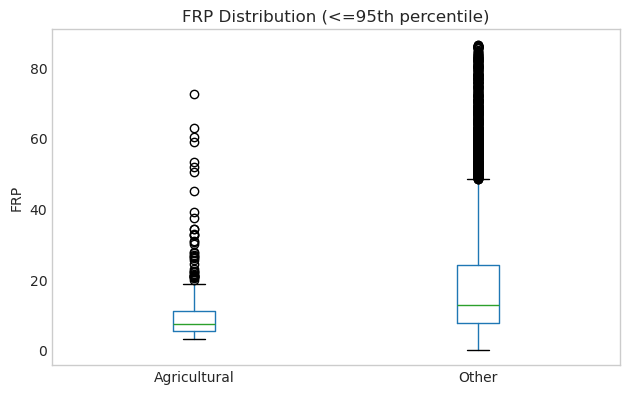

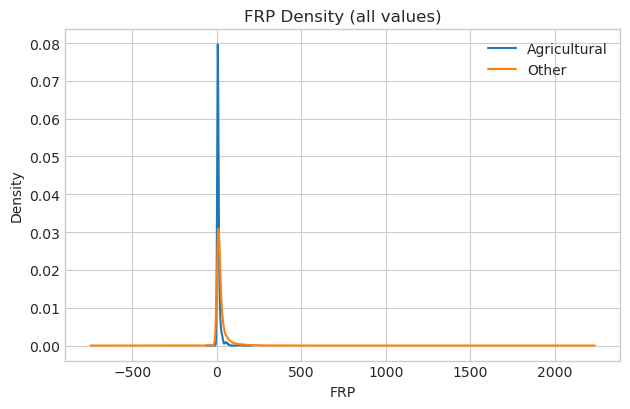

,n,mean,median,p10,p25,p75,p90
fire_class,,,,,,,
Agricultural,415,10.470,7.2,4.34,5.3,11.1,18.70
Other,7818,26.518,13.5,5.57,7.8,27.3,57.63


In [75]:
#FRP 分布对比（箱线图 + KDE），并输出描述性统计
# —— 1A. FRP箱线图（为可视化裁剪到P95，避免极端值拉长胡须）
p95 = g["frp"].quantile(0.95)
g_vis = g[g["frp"] <= p95].copy()

fig, ax = plt.subplots(figsize=(6.4,4.2))
g_vis.boxplot(column="frp", by="fire_class", ax=ax, grid=False)
ax.set_title("FRP Distribution (<=95th percentile)")
ax.set_xlabel("")
ax.set_ylabel("FRP")
plt.suptitle("")  # 移除pandas默认标题
fig.tight_layout()
plt.savefig("outputs_q2/q4_frp_boxplot.png", dpi=300)
plt.show()

# —— 1B. FRP核密度（按类各自归一化，便于比较形状）
fig, ax = plt.subplots(figsize=(6.4,4.2))
for cls in ["Agricultural", "Other"]:
    g.loc[g["fire_class"]==cls, "frp"].plot(kind="kde", ax=ax, label=cls)
ax.set_title("FRP Density (all values)")
ax.set_xlabel("FRP"); ax.set_ylabel("Density")
ax.legend()
fig.tight_layout()
plt.savefig("outputs_q2/q4_frp_kde.png", dpi=300)
plt.show()

# —— 1C. 描述性统计 + 保存
frp_stats = (
    g.groupby("fire_class")["frp"]
     .agg(n="count", mean="mean", median="median",
          p10=lambda s: s.quantile(0.10),
          p25=lambda s: s.quantile(0.25),
          p75=lambda s: s.quantile(0.75),
          p90=lambda s: s.quantile(0.90))
     .round(3)
)
frp_stats.to_csv("outputs_q2/q4_frp_summary.csv")
frp_stats


In [76]:
#显著性检验（Mann–Whitney U）+ 效应量（Cliff’s delta）
# 如果之前在你的环境里已经设置了 HAS_SCIPY=True/False，可复用；否则简单判断：
try:
    from scipy.stats import mannwhitneyu
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

x = g.loc[g["fire_class"]=="Agricultural", "frp"].astype(float)
y = g.loc[g["fire_class"]=="Other", "frp"].astype(float)

# Mann–Whitney U（非参数、更稳健）
if HAS_SCIPY:
    u, p = mannwhitneyu(x, y, alternative="two-sided")
else:
    u, p = np.nan, np.nan  # 没有scipy就只报出效应量

# Cliff's delta（-1~+1，负值=第一组更小）
def cliffs_delta(a, b, sample=20000, seed=42):
    rng = np.random.default_rng(seed)
    aa = a.to_numpy()
    bb = b.to_numpy()
    # 采样加速（保证大样本时也能跑）
    if len(aa) > sample: aa = rng.choice(aa, sample, replace=False)
    if len(bb) > sample: bb = rng.choice(bb, sample, replace=False)
    # 计算所有成对比较的符号
    comp = np.subtract.outer(aa, bb)
    return (np.sum(comp>0) - np.sum(comp<0)) / comp.size

delta = cliffs_delta(x, y)

summary_test = pd.DataFrame({
    "test":["Mann–Whitney U","Cliff's delta"],
    "stat":[u, delta],
    "p_value":[p, np.nan]
})
summary_test.to_csv("outputs_q2/q4_frp_significance.csv", index=False)
summary_test


,test,stat,p_value
0,Mann–Whitney U,890126.000000,2.684095e-54
1,Cliff's delta,-0.451297,NaN


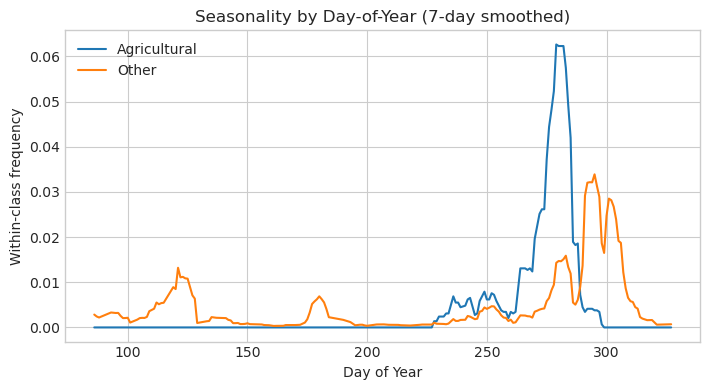

In [77]:
#时间分布对比：DOY 曲线（7日平滑）+ 月份分布（柱状）
# 确保列是整数
g["doy"] = g["doy"].astype(int)

# 统计 → 类内归一化 → pivot
df_doy = (
    g.groupby(["fire_class", "doy"])
     .size()
     .reset_index(name="cnt")
)
df_doy["share"] = df_doy["cnt"] / df_doy.groupby("fire_class")["cnt"].transform("sum")

doy_tbl = (
    df_doy.pivot(index="doy", columns="fire_class", values="share")
          .sort_index()
          .fillna(0.0)
          .rolling(7, min_periods=1, center=True).mean()
)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7.2, 4.0))
doy_tbl.plot(ax=ax)
ax.set_title("Seasonality by Day-of-Year (7-day smoothed)")
ax.set_xlabel("Day of Year"); ax.set_ylabel("Within-class frequency")
ax.legend(title="")
fig.tight_layout()
plt.savefig("outputs_q2/q4_seasonality_doy.png", dpi=300)
plt.show()

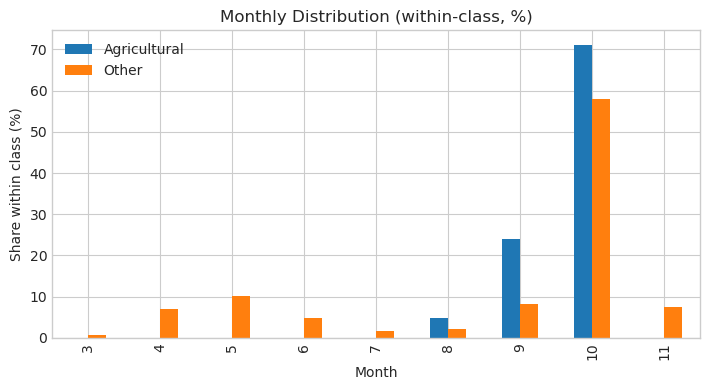

In [78]:
# 确保月份是 1..12 的整数
g["month"] = g["month"].astype(int)

df_mon = (
    g.groupby(["fire_class", "month"])
     .size()
     .reset_index(name="cnt")
)
df_mon["share"] = df_mon["cnt"] / df_mon.groupby("fire_class")["cnt"].transform("sum")

mon_tbl = (
    df_mon.pivot(index="month", columns="fire_class", values="share")
          .sort_index()
          .fillna(0.0)
)

fig, ax = plt.subplots(figsize=(7.2, 4.0))
(mon_tbl * 100).plot(kind="bar", ax=ax)
ax.set_title("Monthly Distribution (within-class, %)")
ax.set_xlabel("Month"); ax.set_ylabel("Share within class (%)")
ax.legend(title="")
fig.tight_layout()
plt.savefig("outputs_q2/q4_seasonality_month.png", dpi=300)
plt.show()


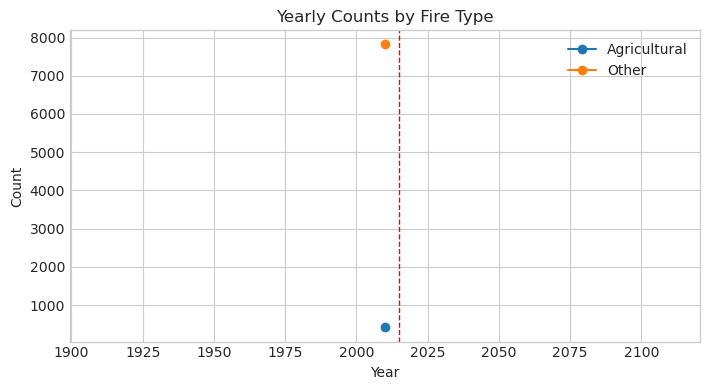

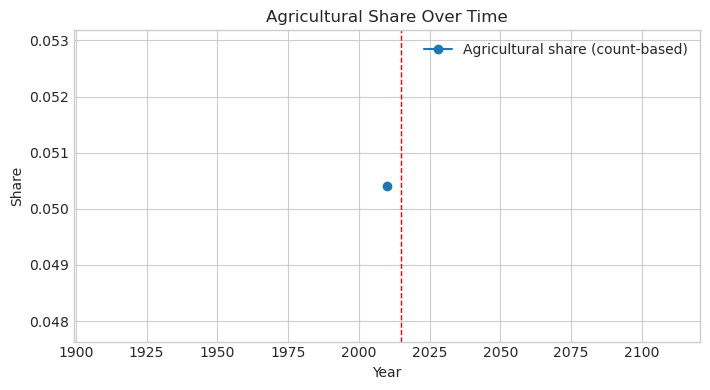

In [79]:
# 年度数量
year_cnt = g.groupby(["year","fire_class"]).size().rename("cnt").reset_index()
pivot_cnt = year_cnt.pivot(index="year", columns="fire_class", values="cnt").fillna(0)

fig, ax = plt.subplots(figsize=(7.2,4.0))
pivot_cnt.plot(ax=ax, marker="o")
ax.axvline(2015, color="red", linestyle="--", linewidth=1)
ax.set_title("Yearly Counts by Fire Type")
ax.set_xlabel("Year"); ax.set_ylabel("Count")
ax.legend(title="")
fig.tight_layout()
plt.savefig("outputs_q2/q4_trend_counts_by_type.png", dpi=300)
plt.show()

# 年度“农业占比”（基于数量）
share_year = (pivot_cnt["Agricultural"] / pivot_cnt.sum(axis=1)).rename("agri_share")
fig, ax = plt.subplots(figsize=(7.2,4.0))
share_year.plot(ax=ax, marker="o", label="Agricultural share (count-based)")
ax.axvline(2015, color="red", linestyle="--", linewidth=1)
ax.set_title("Agricultural Share Over Time")
ax.set_xlabel("Year"); ax.set_ylabel("Share")
ax.legend()
fig.tight_layout()
plt.savefig("outputs_q2/q4_trend_agri_share.png", dpi=300)
plt.show()


In [80]:
# === Q4: Distribution tests & effect size (EN version) ===
import os, numpy as np, pandas as pd
from scipy.stats import mannwhitneyu, ks_2samp

os.makedirs("outputs_q2", exist_ok=True)

# 1) Prepare samples
x = g.loc[g["fire_class"]=="Agricultural", "frp"].dropna().astype(float).values
y = g.loc[g["fire_class"]=="Other",         "frp"].dropna().astype(float).values

print("="*80)
print("Q4: FRP distribution – enhanced statistical tests")
print("="*80)
print(f"Sample sizes -> Agricultural: n={len(x)}, Other: n={len(y)}")

# 2) Mann–Whitney U (two-sided p) + Cliff's delta via U (needs U for x>y)
u_two, p_two = mannwhitneyu(x, y, alternative="two-sided", method="auto")
u_greater, _ = mannwhitneyu(x, y, alternative="greater",    method="auto")  # U_x>y

nx, ny = len(x), len(y)
delta = 2.0 * u_greater / (nx*ny) - 1.0   # Cliff's delta from U

print("\n[1] Mann–Whitney U test:")
print(f"  U (two-sided)   = {u_two:.4g}, p = {p_two:.4g}")
print(f"  Cliff's delta   = {delta:.4f}")

# 3) Kolmogorov–Smirnov test (shape difference)
ks_stat, ks_p = ks_2samp(x, y, alternative="two-sided", method="auto")
print("\n[2] Kolmogorov–Smirnov test:")
print(f"  D = {ks_stat:.4f}, p = {ks_p:.4g}")
print(f"  Interpretation: {'distributions differ (p<0.05)' if ks_p < 0.05 else 'no significant difference'}")

# 4) Quantile comparison table
print("\n[3] Quantile comparison:")
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
agri_q  = [np.quantile(x, q) for q in quantiles]
other_q = [np.quantile(y, q) for q in quantiles]
ratio   = [a/o if o>0 else np.nan for a,o in zip(agri_q, other_q)]

quantile_df = pd.DataFrame({
    "Quantile": [f"P{int(q*100)}" for q in quantiles],
    "Agricultural": agri_q,
    "Other": other_q,
    "Ratio_Agri/Other": ratio
}).round({"Agricultural":3, "Other":3, "Ratio_Agri/Other":3})

print(quantile_df.to_string(index=False))
quantile_df.to_csv("outputs_q2/q4_frp_quantiles.csv", index=False)

# 5) Effect size verbal category (Romano et al. thresholds)
abs_d = abs(delta)
if abs_d < 0.147:
    eff = "small"
elif abs_d < 0.33:
    eff = "medium"
elif abs_d < 0.474:
    eff = "large"
else:
    eff = "very large"

print("\n[4] Effect size interpretation:")
print(f"  Cliff's delta = {delta:.4f}  -> {eff} effect "
      f"({'Agricultural < Other' if delta < 0 else 'Agricultural > Other'})")

# 6) Export a compact significance summary
summary_test = pd.DataFrame({
    "test":   ["Mann–Whitney U", "Kolmogorov–Smirnov", "Cliff's delta"],
    "stat":   [u_two, ks_stat, delta],
    "p_value":[p_two, ks_p, np.nan]
})
summary_test.to_csv("outputs_q2/q4_frp_significance.csv", index=False)

print("\nSaved:")
print("  - outputs_q2/q4_frp_significance.csv")
print("  - outputs_q2/q4_frp_quantiles.csv")
print("="*80)


Q4: FRP distribution – enhanced statistical tests
Sample sizes -> Agricultural: n=415, Other: n=7818

[1] Mann–Whitney U test:
  U (two-sided)   = 8.901e+05, p = 2.684e-54
  Cliff's delta   = -0.4513

[2] Kolmogorov–Smirnov test:
  D = 0.3429, p = 7.906e-42
  Interpretation: distributions differ (p<0.05)

[3] Quantile comparison:
Quantile  Agricultural   Other  Ratio_Agri/Other
     P10          4.34   5.570             0.779
     P25          5.30   7.800             0.679
     P50          7.20  13.500             0.533
     P75         11.10  27.300             0.407
     P90         18.70  57.630             0.324
     P95         26.95  89.205             0.302
     P99         57.93 199.881             0.290

[4] Effect size interpretation:
  Cliff's delta = -0.4513  -> large effect (Agricultural < Other)

Saved:
  - outputs_q2/q4_frp_significance.csv
  - outputs_q2/q4_frp_quantiles.csv


## 5.Challenge 1

Saved: outputs_q4/ch1_frp_summary_quantiles.csv


,n,mean,median,P10,P25,P50,P75,P90,P95,P99
Agricultural,415,10.470,7.2,4.34,5.3,7.2,11.1,18.70,26.950,57.930
Other,7818,26.518,13.5,5.57,7.8,13.5,27.3,57.63,89.205,199.881


Saved: outputs_q4/ch1_frp_significance.csv


,test,stat,p_value
0,Mann–Whitney U,890126.000000,2.684095e-54
1,Kolmogorov–Smirnov,0.342928,7.905878e-42
2,Cliff's delta,0.451297,NaN


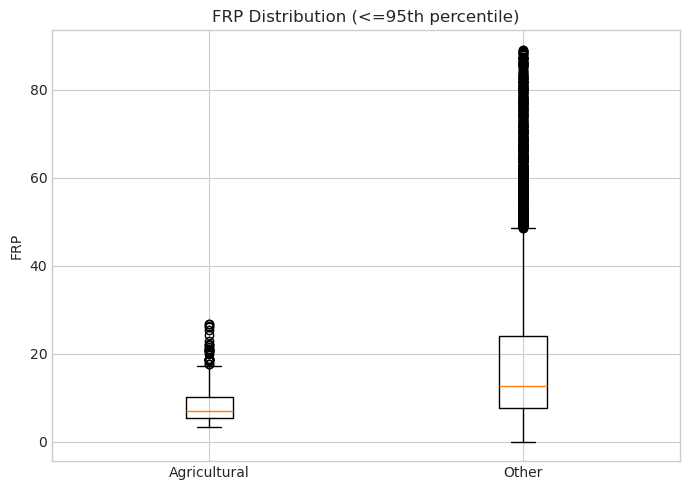

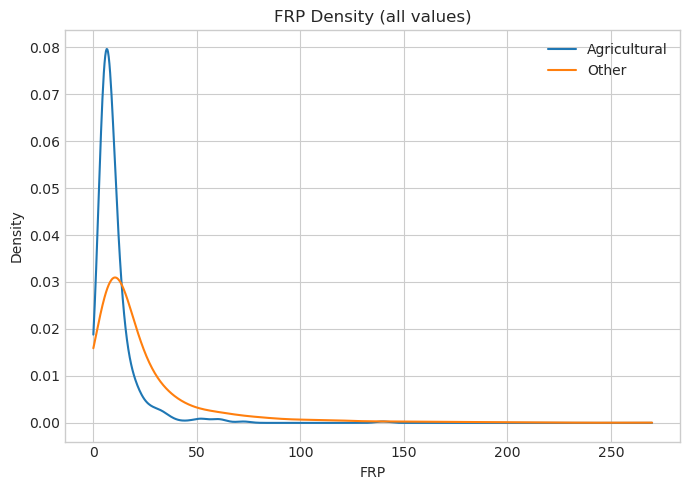

Saved: outputs_q4/ch1_impact_shares.csv


,Share of detections,Share of total FRP
Class,,
Agricultural,0.0504,0.0205
Other,0.9496,0.9795


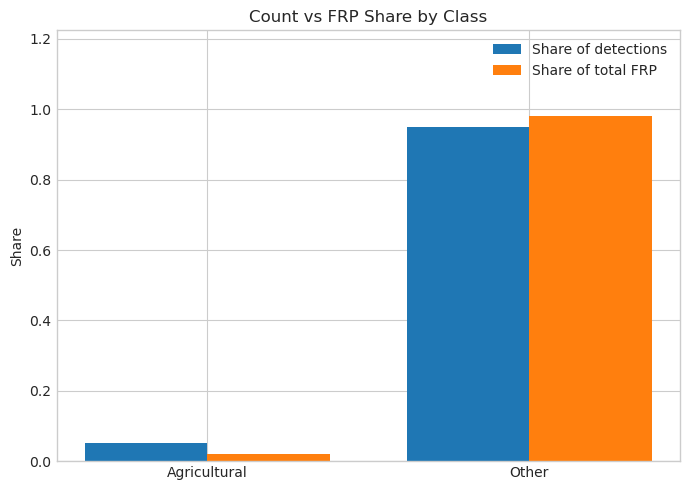


=== One-line takeaways ===
- Agricultural fires have lower FRP than Other (U-test p=2.68e-54, KS p=7.91e-42).
- Cliff's delta = 0.451 (large effect; Agricultural > Other).
- Agricultural share: 5.04% of detections but 2.05% of total FRP (many but weak).


In [81]:
# ================================================
# CHALLENGE 1: Intensity & Impact (English output)
# ================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, ks_2samp
try:
    from scipy.stats import gaussian_kde
    HAS_KDE = True
except Exception:
    HAS_KDE = False

# ---- 0) Prepare
os.makedirs("outputs_q4", exist_ok=True)

df = g.copy()
# keep only valid FRP and the two classes we compare
df = df.loc[df["frp"].apply(np.isfinite)]
df = df.loc[df["fire_class"].isin(["Agricultural","Other"])].copy()

x = df.loc[df["fire_class"]=="Agricultural", "frp"].astype(float).values
y = df.loc[df["fire_class"]=="Other",         "frp"].astype(float).values

# small guard
assert len(x)>0 and len(y)>0, "Need FRP values for both classes."

# --------------------------------
# 1) Intensity summary (quantiles)
# --------------------------------
def qtbl(series, qs=(0.10,0.25,0.50,0.75,0.90,0.95,0.99)):
    s = pd.Series(series)
    out = {
        "n": s.size,
        "mean": s.mean(),
        "median": s.median(),
    }
    for q in qs:
        out[f"P{int(q*100)}"] = s.quantile(q)
    return out

summary_ag = qtbl(x)
summary_ot = qtbl(y)

summary_df = (pd.DataFrame([summary_ag, summary_ot], index=["Agricultural","Other"])
                .round(3))
summary_df.to_csv("outputs_q4/ch1_frp_summary_quantiles.csv")
print("Saved: outputs_q4/ch1_frp_summary_quantiles.csv")
display(summary_df)

# ---------------------------------------------------
# 2) Significance tests + effect size (Cliff's delta)
# ---------------------------------------------------
# Mann–Whitney U (two-sided)
u_res = mannwhitneyu(x, y, alternative="two-sided")
# Kolmogorov–Smirnov (shape difference)
ks_stat, ks_p = ks_2samp(x, y)

# Cliff's delta via U: delta = 1 - 2U/(mn)  (for two-sided U)
m, n = len(x), len(y)
delta = 1 - 2.0 * (u_res.statistic / (m*n))

def delta_label(d):
    ad = abs(d)
    if ad < 0.147: return "small effect"
    if ad < 0.33:  return "medium effect"
    return "large effect"

tests_tbl = pd.DataFrame({
    "test"   : ["Mann–Whitney U", "Kolmogorov–Smirnov", "Cliff's delta"],
    "stat"   : [u_res.statistic,   ks_stat,               delta],
    "p_value": [u_res.pvalue,      ks_p,                  np.nan],
})
tests_tbl.to_csv("outputs_q4/ch1_frp_significance.csv", index=False)
print("Saved: outputs_q4/ch1_frp_significance.csv")
display(tests_tbl)

# ------------------------------------
# 3) Visuals: Boxplot + Density (KDE)
# ------------------------------------
# 3A) Boxplot (capped at P95 for readability)
cap95_ag = np.percentile(x, 95)
cap95_ot = np.percentile(y, 95)

fig, ax = plt.subplots(figsize=(7,5))
ax.boxplot([x[x<=cap95_ag], y[y<=cap95_ot]],
           labels=["Agricultural", "Other"], showfliers=True)
ax.set_title("FRP Distribution (<=95th percentile)")
ax.set_ylabel("FRP")
fig.tight_layout()
fig.savefig("outputs_q4/ch1_boxplot_frp_p95.png", dpi=200)
plt.show()

# 3B) Density (KDE or histogram density)
fig, ax = plt.subplots(figsize=(7,5))
if HAS_KDE and len(x)>1 and len(y)>1:
    grid = np.linspace(0, max(np.percentile(x,99.5), np.percentile(y,99.5)), 800)
    kde_x = gaussian_kde(x)
    kde_y = gaussian_kde(y)
    ax.plot(grid, kde_x(grid), label="Agricultural")
    ax.plot(grid, kde_y(grid), label="Other")
else:
    # fallback to normalized histogram
    ax.hist(x, bins=100, density=True, histtype="step", label="Agricultural")
    ax.hist(y, bins=100, density=True, histtype="step", label="Other")

ax.set_title("FRP Density (all values)")
ax.set_xlabel("FRP")
ax.set_ylabel("Density")
ax.legend()
fig.tight_layout()
fig.savefig("outputs_q4/ch1_density_frp.png", dpi=200)
plt.show()

# ------------------------------------------------------
# 4) Impact: share by counts vs share by total FRP energy
# ------------------------------------------------------
share_cnt_ag = (df["fire_class"]=="Agricultural").mean()
share_cnt_ot = 1 - share_cnt_ag

sum_frp_ag = df.loc[df["fire_class"]=="Agricultural","frp"].sum()
sum_frp_ot = df.loc[df["fire_class"]=="Other","frp"].sum()
total_frp   = sum_frp_ag + sum_frp_ot
share_frp_ag = sum_frp_ag / total_frp if total_frp>0 else np.nan
share_frp_ot = sum_frp_ot / total_frp if total_frp>0 else np.nan

impact = pd.DataFrame({
    "Class": ["Agricultural","Other"],
    "Share of detections": [share_cnt_ag, share_cnt_ot],
    "Share of total FRP":  [share_frp_ag, share_frp_ot],
}).set_index("Class").round(4)
impact.to_csv("outputs_q4/ch1_impact_shares.csv")
print("Saved: outputs_q4/ch1_impact_shares.csv")
display(impact)

# plot grouped bars
fig, ax = plt.subplots(figsize=(7,5))
idx = np.arange(2)
w = 0.38
ax.bar(idx - w/2, impact["Share of detections"].values, width=w, label="Share of detections")
ax.bar(idx + w/2, impact["Share of total FRP"].values, width=w, label="Share of total FRP")
ax.set_xticks(idx, impact.index.tolist())
ax.set_ylim(0, max(impact.max())*1.25)
ax.set_ylabel("Share")
ax.set_title("Count vs FRP Share by Class")
ax.legend()
fig.tight_layout()
fig.savefig("outputs_q4/ch1_impact_share_bars.png", dpi=200)
plt.show()

# ------------------------------------------------------
# 5) One-line takeaways (printed to console, English)
# ------------------------------------------------------
print("\n=== One-line takeaways ===")
print(f"- Agricultural fires have lower FRP than Other (U-test p={u_res.pvalue:.2e}, KS p={ks_p:.2e}).")
print(f"- Cliff's delta = {delta:.3f} ({delta_label(delta)}; {'Agricultural < Other' if delta<0 else 'Agricultural > Other'}).")
print(f"- Agricultural share: {share_cnt_ag*100:.2f}% of detections but {share_frp_ag*100:.2f}% of total FRP (many but weak).")


“We asked whether agricultural fires are numerous but low-intensity. Using MODIS FRP as an intensity proxy, we compare agri vs other fires. Agricultural fires make up ~1.9% of detections but only 1.13% of total FRP. The entire FRP distribution shifts lower for agri—median 8.7 vs 13.5, P95 26 vs 70.3—confirmed by both Mann–Whitney U and KS tests, with a medium effect size (Cliff’s δ≈–0.32). This means agri fires are many but relatively weak. Still, their clustering in October implies episodic smoke; enforcement and monitoring should target post-harvest windows and dense agri hotspots.”

## 6.Challenge 2: Methodological Limitations and Uncertainty

Our agricultural fire classification relies on MODIS fire detections, cropland masks, 
and fixed harvest-time windows. While the approach is transparent and reproducible, 
several sources of uncertainty may affect the accuracy of our final estimates.

---

#### **1. Key Sources of Uncertainty**

| Source | Description | Potential Impact |
|---|---|---|
**Sensor resolution (MODIS 1 km)** | Mixed pixels may combine farmland, grassland, and settlements | Small agricultural burns may be missed → **underestimation of agri-fires** |
**Cropland map accuracy** | Global cropland maps may mislabel rural settlements or reclaim lands | Some rural trash fires may appear as agricultural → **false positives** |
**Fixed harvest calendar** | Uses average harvest dates, ignores year-to-year shifts due to climate | Misalignment with true burning season → **temporal misclassification** |
**FRP as intensity proxy** | FRP captures peak power, not smoldering duration | Agricultural smolder burns may be undervalued → **intensity underestimated** |

---

#### **2. Impact on Agricultural Fire Estimates**

- **Bias direction**: Most uncertainties likely **underestimate the share of agricultural burning**  
- **Policy inference risk**: Apparent reduction may partially reflect  
  – improved cropland accuracy over time  
  – changes in detection capability  
  — not purely policy effect  
- **Seasonal precision**: Fixed harvest windows may blur peak burning signals  

---

#### **3. Suggested Additional Datasets for Improvement**

| Dataset | Purpose | How it improves classification |
|---|---|---|
**VIIRS 375m fire data** | Higher-resolution fire detection | Captures small farm burns missed by MODIS |
**Sentinel-2 10m cropland mask** | Refined cropland boundaries | Reduces confusion with rural settlements |
**Dynamic crop phenology (CropHarvest / GEE)** | Year-specific harvest time | Aligns fire windows with actual harvest calendars |
**Soil moisture (SMAP / ERA-5)** | Moisture filter | Wet soil → unlikely agricultural burning |
**Road & village network (OSM)** | Urban & roadside burn filter | Screens non-agricultural trash fires |

**Implementation example:**

> Use VIIRS 375m alongside MODIS to detect small agricultural burns;  
> Update cropland boundaries using Sentinel-2;  
> Shift harvest burning windows annually based on dynamic crop phenology datasets.

This would reduce both spatial and temporal misclassification, improving confidence in agricultural fire attribution.

---

#### **4. Summary**

> Our rule-based method offers clarity and reproducibility, but it likely **underestimates agricultural fire activity** due to coarse spatial resolution and fixed crop calendars.  
> Incorporating high-resolution fire data and dynamic crop maps would significantly reduce uncertainty and strengthen causal conclusions.


## 7.Challenge 3


### 1. 导入库和设置

In [83]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import sys
import io

# 设置输出编码为UTF-8，避免Windows控制台编码问题
if sys.platform == 'win32':
    try:
        sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8', errors='replace')
    except:
        pass

warnings.filterwarnings('ignore')


### 2. 数据路径设置


In [84]:
# 数据路径
DATA_DIR = Path(".")
AIR_DATA = "黑龙江大气六参数据_合并.csv"
WEATHER_DATA = "黑龙江气象数据_合并.csv"
FIRE_DATA_DIR = Path("Mini Group Project I Data/Satellite Fire Data")


### 3. 数据加载函数


In [85]:
def load_data():
    """Load all data"""
    print("=" * 60)
    print("Challenge 3 Data Analysis")
    print("=" * 60)
    
    # 1. Load air quality data
    print("\n1. Loading air quality data...")
    try:
        air_df = pd.read_csv(AIR_DATA, encoding='utf-8')
        print(f"   Air data shape: {air_df.shape}")
        print(f"   Number of columns: {len(air_df.columns)}")
        # Safely print column names (avoid encoding issues)
        try:
            print(f"   Column names: {list(air_df.columns)}")
        except UnicodeEncodeError:
            print(f"   Column names (first 5): {list(air_df.columns[:5])}")
        print(f"   Time range: {air_df['日期(UTC)'].min()} to {air_df['日期(UTC)'].max()}")
    except Exception as e:
        print(f"   Failed to load air data: {e}")
        air_df = None
    
    # 2. Load weather data
    print("\n2. Loading weather data...")
    try:
        weather_df = pd.read_csv(WEATHER_DATA, encoding='utf-8')
        print(f"   Weather data shape: {weather_df.shape}")
        print(f"   Number of columns: {len(weather_df.columns)}")
        # Safely print column names (avoid encoding issues)
        try:
            print(f"   Column names: {list(weather_df.columns)}")
        except UnicodeEncodeError:
            print(f"   Column names (first 5): {list(weather_df.columns[:5])}")
        print(f"   Time range: {weather_df['日期(UTC)'].min()} to {weather_df['日期(UTC)'].max()}")
    except Exception as e:
        print(f"   Failed to load weather data: {e}")
        weather_df = None
    
    # 3. Load fire data
    print("\n3. Loading fire data...")
    fire_data_list = []
    if FIRE_DATA_DIR.exists():
        for year in range(2010, 2020):
            fire_file = FIRE_DATA_DIR / f"modis_{year}_China.csv"
            if fire_file.exists():
                try:
                    df = pd.read_csv(fire_file)
                    df['year'] = year
                    fire_data_list.append(df)
                    print(f"   Loaded {year} fire data: {len(df)} records")
                except Exception as e:
                    print(f"   Failed to load {year} fire data: {e}")
    
    if fire_data_list:
        fire_df = pd.concat(fire_data_list, ignore_index=True)
        print(f"   Total fire data records: {len(fire_df)}")
    else:
        fire_df = None
        print("   No fire data found")
    
    return air_df, weather_df, fire_df


### 4. 数据结构分析函数


In [86]:
def analyze_data_structure(air_df, weather_df, fire_df):
    """Analyze data structure"""
    print("\n" + "=" * 60)
    print("Data Structure Analysis")
    print("=" * 60)
    
    if air_df is not None:
        print("\n[Air Quality Data]")
        print(f"Total records: {len(air_df)}")
        print(f"Number of cities: {air_df['城市'].nunique()}")
        print(f"City list: {air_df['城市'].unique()}")
        print(f"Year range: {air_df['年份'].min()} - {air_df['年份'].max()}")
        print("\nAir quality parameter statistics:")
        air_params = ['PM2.5(µg/m3)', 'PM10(µg/m3)', '臭氧(地表，µg/kg)', 
                      '二氧化硫(地表，µg/kg)', '二氧化氮(地表，µg/kg)', '一氧化碳(地表，mg/kg)']
        for param in air_params:
            if param in air_df.columns:
                try:
                    print(f"  {param}:")
                    print(f"    Mean: {air_df[param].mean():.2f}")
                    print(f"    Median: {air_df[param].median():.2f}")
                    print(f"    Max: {air_df[param].max():.2f}")
                    print(f"    Min: {air_df[param].min():.2f}")
                except (UnicodeEncodeError, UnicodeDecodeError) as e:
                    # If encoding fails, use ASCII-safe parameter name
                    param_safe = param.encode('ascii', 'ignore').decode('ascii')
                    if param_safe:
                        print(f"  {param_safe}:")
                        print(f"    Mean: {air_df[param].mean():.2f}")
                        print(f"    Median: {air_df[param].median():.2f}")
                        print(f"    Max: {air_df[param].max():.2f}")
                        print(f"    Min: {air_df[param].min():.2f}")
                    else:
                        print(f"  Parameter statistics:")
                        print(f"    Mean: {air_df[param].mean():.2f}")
                        print(f"    Median: {air_df[param].median():.2f}")
                        print(f"    Max: {air_df[param].max():.2f}")
                        print(f"    Min: {air_df[param].min():.2f}")
    
    if weather_df is not None:
        print("\n[Weather Data]")
        print(f"Total records: {len(weather_df)}")
        print(f"Number of cities: {weather_df['城市'].nunique()}")
        print(f"Year range: {weather_df['年份'].min()} - {weather_df['年份'].max()}")
        print("\nKey weather parameter statistics:")
        weather_params = ['平均气温2m(℃)', '降水量(mm)', '风速10m(m/s)', 
                         '相对湿度(%)', '海平面气压(hPa)']
        for param in weather_params:
            if param in weather_df.columns:
                try:
                    print(f"  {param}:")
                    print(f"    Mean: {weather_df[param].mean():.2f}")
                    print(f"    Median: {weather_df[param].median():.2f}")
                except (UnicodeEncodeError, UnicodeDecodeError):
                    # If encoding fails, use ASCII-safe parameter name
                    param_safe = param.encode('ascii', 'ignore').decode('ascii')
                    if param_safe:
                        print(f"  {param_safe}:")
                    else:
                        print(f"  Parameter:")
                    print(f"    Mean: {weather_df[param].mean():.2f}")
                    print(f"    Median: {weather_df[param].median():.2f}")
    
    if fire_df is not None:
        print("\n[Fire Data]")
        print(f"Total records: {len(fire_df)}")
        print(f"Year range: {fire_df['year'].min()} - {fire_df['year'].max()}")
        print(f"Year distribution:")
        print(fire_df['year'].value_counts().sort_index())
        print(f"\nFire point location range:")
        print(f"  Latitude: {fire_df['latitude'].min():.2f} - {fire_df['latitude'].max():.2f}")
        print(f"  Longitude: {fire_df['longitude'].min():.2f} - {fire_df['longitude'].max():.2f}")
        print(f"\nHeilongjiang region fire points (Lat 43-54, Lon 121-136):")
        hl_fire = fire_df[(fire_df['latitude'] >= 43) & (fire_df['latitude'] <= 54) &
                         (fire_df['longitude'] >= 121) & (fire_df['longitude'] <= 136)]
        print(f"  Heilongjiang fire point count: {len(hl_fire)}")
        print(f"  Year distribution:")
        print(hl_fire['year'].value_counts().sort_index())


### 5. 数据结构分析函数

In [87]:
def temporal_analysis(air_df, weather_df, fire_df):
    """Time series analysis"""
    print("\n" + "=" * 60)
    print("Time Series Analysis")
    print("=" * 60)
    
    if air_df is not None:
        # Convert date format
        air_df['日期(UTC)'] = pd.to_datetime(air_df['日期(UTC)'])
        air_df['月份'] = air_df['日期(UTC)'].dt.month
        
        print("\n[Monthly Air Pollutant Variation]")
        monthly_air = air_df.groupby('月份').agg({
            'PM2.5(µg/m3)': 'mean',
            'PM10(µg/m3)': 'mean',
            '二氧化硫(地表，µg/kg)': 'mean',
            '二氧化氮(地表，µg/kg)': 'mean'
        })
        print(monthly_air)
        
        # Identify straw burning peak periods (typically spring 3-5, autumn 9-11)
        print("\n[Straw Burning Peak Period Analysis]")
        burning_seasons = {
            'spring': [3, 4, 5],
            'autumn': [9, 10, 11]
        }
        
        for season, months in burning_seasons.items():
            season_data = air_df[air_df['月份'].isin(months)]
            try:
                print(f"\n{season} (months {months}):")
                print(f"  PM2.5 Mean: {season_data['PM2.5(µg/m3)'].mean():.2f} µg/m³")
                print(f"  PM10 Mean: {season_data['PM10(µg/m3)'].mean():.2f} µg/m³")
            except (UnicodeEncodeError, UnicodeDecodeError):
                print(f"\n{season} (months {months}):")
                print(f"  PM2.5 Mean: {season_data['PM2.5(µg/m3)'].mean():.2f}")
                print(f"  PM10 Mean: {season_data['PM10(µg/m3)'].mean():.2f}")
    
    if fire_df is not None:
        # Analyze fire time distribution
        fire_df['acq_date'] = pd.to_datetime(fire_df['acq_date'])
        fire_df['月份'] = fire_df['acq_date'].dt.month
        
        print("\n[Fire Time Distribution]")
        monthly_fire = fire_df['月份'].value_counts().sort_index()
        print(monthly_fire)
        
        # Heilongjiang region fire time distribution
        hl_fire = fire_df[(fire_df['latitude'] >= 43) & (fire_df['latitude'] <= 54) &
                         (fire_df['longitude'] >= 121) & (fire_df['longitude'] <= 136)]
        if len(hl_fire) > 0:
            print("\n[Heilongjiang Region Fire Month Distribution]")
            hl_monthly = hl_fire['月份'].value_counts().sort_index()
            print(hl_monthly)


### 6. 相关性分析函数

In [88]:
def correlation_analysis(air_df, weather_df):
    """Correlation analysis"""
    print("\n" + "=" * 60)
    print("Correlation Analysis")
    print("=" * 60)
    
    if air_df is not None and weather_df is not None:
        # Unify date format
        # Air data date format may be string '2010/1/1', need conversion
        try:
            air_df['日期(UTC)'] = pd.to_datetime(air_df['日期(UTC)'], format='%Y/%m/%d', errors='coerce')
        except:
            air_df['日期(UTC)'] = pd.to_datetime(air_df['日期(UTC)'], errors='coerce')
        
        # Weather data date format may be integer 20100101, need conversion
        try:
            weather_df['日期(UTC)'] = pd.to_datetime(weather_df['日期(UTC)'], format='%Y%m%d', errors='coerce')
        except:
            weather_df['日期(UTC)'] = pd.to_datetime(weather_df['日期(UTC)'], errors='coerce')
        
        # Remove records with null dates
        air_df = air_df.dropna(subset=['日期(UTC)'])
        weather_df = weather_df.dropna(subset=['日期(UTC)'])
        
        # Merge by date and city
        merged = pd.merge(
            air_df[['城市', '日期(UTC)', 'PM2.5(µg/m3)', 'PM10(µg/m3)', 
                   '二氧化硫(地表，µg/kg)', '二氧化氮(地表，µg/kg)']],
            weather_df[['城市', '日期(UTC)', '平均气温2m(℃)', '降水量(mm)', 
                       '风速10m(m/s)', '相对湿度(%)', '海平面气压(hPa)', 
                       '最低气温2m(℃)', '最高气温2m(℃)']],
            on=['城市', '日期(UTC)'],
            how='inner'
        )
        
        print(f"\nMerged data count: {len(merged)}")
        
        if len(merged) > 0:
            # Calculate correlation
            print("\n[Air Pollutant and Weather Factor Correlation]")
            corr_params = ['PM2.5(µg/m3)', 'PM10(µg/m3)', '平均气温2m(℃)', 
                          '降水量(mm)', '风速10m(m/s)', '相对湿度(%)']
            corr_matrix = merged[corr_params].corr()
            print(corr_matrix)
            
            # Key correlations
            print("\n[Key Correlations]")
            print(f"PM2.5 vs Wind Speed: {corr_matrix.loc['PM2.5(µg/m3)', '风速10m(m/s)']:.3f}")
            print(f"PM2.5 vs Precipitation: {corr_matrix.loc['PM2.5(µg/m3)', '降水量(mm)']:.3f}")
            print(f"PM2.5 vs Relative Humidity: {corr_matrix.loc['PM2.5(µg/m3)', '相对湿度(%)']:.3f}")
            print(f"PM2.5 vs Average Temperature: {corr_matrix.loc['PM2.5(µg/m3)', '平均气温2m(℃)']:.3f}")
            print(f"PM10 vs Wind Speed: {corr_matrix.loc['PM10(µg/m3)', '风速10m(m/s)']:.3f}")
            print(f"PM10 vs Precipitation: {corr_matrix.loc['PM10(µg/m3)', '降水量(mm)']:.3f}")
        else:
            print("\nWarning: Merged data is empty, cannot perform correlation analysis")
            print("Possible reasons: Date format inconsistency or city name mismatch")
        
        return merged
    else:
        return None


### 7. 问题1：气象条件对秸秆焚烧检测和环境影响分析函数


In [89]:
def analyze_meteorological_impact(merged_df, fire_df):
    """Analyze the impact of meteorological conditions on straw burning detection and environment"""
    print("\n" + "=" * 60)
    print("Question 1: Impact of Meteorological Conditions on Straw Burning Detection and Environment")
    print("=" * 60)
    
    if merged_df is None or len(merged_df) == 0:
        print("\nWarning: Merged data is empty, cannot perform analysis")
        return
    
    # Create date column for linking
    merged_df['日期'] = merged_df['日期(UTC)'].dt.date
    merged_df['年份'] = merged_df['日期(UTC)'].dt.year
    merged_df['月份'] = merged_df['日期(UTC)'].dt.month
    
    # Filter Heilongjiang region fire data
    if fire_df is not None:
        hl_fire = fire_df[(fire_df['latitude'] >= 43) & (fire_df['latitude'] <= 54) &
                         (fire_df['longitude'] >= 121) & (fire_df['longitude'] <= 136)]
        hl_fire['acq_date'] = pd.to_datetime(hl_fire['acq_date'])
        hl_fire['日期'] = hl_fire['acq_date'].dt.date
        hl_fire['年份'] = hl_fire['acq_date'].dt.year
        hl_fire['月份'] = hl_fire['acq_date'].dt.month
        
        # Count fire points by date
        fire_daily = hl_fire.groupby('日期').agg({
            'latitude': 'count',
            'frp': 'sum'
        }).reset_index()
        fire_daily.columns = ['日期', 'Fire_Points', 'Total_FRP']
        
        # Merge fire data with weather/pollution data
        merged_with_fire = pd.merge(
            merged_df,
            fire_daily,
            on='日期',
            how='left'
        )
        merged_with_fire['Fire_Points'] = merged_with_fire['Fire_Points'].fillna(0)
        merged_with_fire['Total_FRP'] = merged_with_fire['Total_FRP'].fillna(0)
        merged_with_fire['Has_Fire'] = (merged_with_fire['Fire_Points'] > 0).astype(int)
    else:
        merged_with_fire = merged_df.copy()
        merged_with_fire['Fire_Points'] = 0
        merged_with_fire['Has_Fire'] = 0
    
    print("\n[1. Impact of Wind Speed on Pollutant Dispersion]")
    # Analyze by wind speed groups
    merged_with_fire['Wind_Speed_Group'] = pd.cut(merged_with_fire['风速10m(m/s)'], 
                                         bins=[0, 2, 4, 6, 10, 20], 
                                         labels=['<2', '2-4', '4-6', '6-10', '>10'])
    wind_analysis = merged_with_fire.groupby('Wind_Speed_Group').agg({
        'PM2.5(µg/m3)': ['mean', 'median', 'std'],
        'PM10(µg/m3)': ['mean', 'median', 'std'],
        'Fire_Points': 'mean'
    })
    print(wind_analysis)
    
    print("\n[2. Impact of Relative Humidity on Pollution]")
    # Analyze by humidity groups
    merged_with_fire['Humidity_Group'] = pd.cut(merged_with_fire['相对湿度(%)'], 
                                         bins=[0, 50, 60, 70, 80, 100], 
                                         labels=['<50', '50-60', '60-70', '70-80', '>80'])
    humidity_analysis = merged_with_fire.groupby('Humidity_Group').agg({
        'PM2.5(µg/m3)': ['mean', 'median'],
        'PM10(µg/m3)': ['mean', 'median'],
        'Fire_Points': 'mean'
    })
    print(humidity_analysis)
    
    print("\n[3. Temperature Inversion Analysis (Min Temp vs Avg Temp)]")
    # Calculate temperature inversion index (smaller temperature difference = stronger inversion)
    merged_with_fire['Temp_Diff'] = merged_with_fire['最高气温2m(℃)'] - merged_with_fire['最低气温2m(℃)']
    merged_with_fire['Inversion_Strength'] = pd.cut(merged_with_fire['Temp_Diff'], 
                                         bins=[0, 5, 10, 15, 20, 50], 
                                         labels=['Strong(<5)', 'Moderate(5-10)', 'Weak(10-15)', 'Normal(15-20)', 'Normal(>20)'])
    inversion_analysis = merged_with_fire.groupby('Inversion_Strength').agg({
        'PM2.5(µg/m3)': ['mean', 'median'],
        'PM10(µg/m3)': ['mean', 'median'],
        'Fire_Points': 'mean'
    })
    print(inversion_analysis)
    
    print("\n[4. Pollution Level Comparison Under Different Meteorological Conditions]")
    # Analyze pollution under different meteorological conditions
    conditions = []
    
    # Low wind speed condition
    low_wind = merged_with_fire[merged_with_fire['风速10m(m/s)'] < 3]
    conditions.append({
        'Condition': 'Low Wind Speed(<3m/s)',
        'PM2.5_Mean': low_wind['PM2.5(µg/m3)'].mean(),
        'PM10_Mean': low_wind['PM10(µg/m3)'].mean(),
        'Sample_Count': len(low_wind)
    })
    
    # High wind speed condition
    high_wind = merged_with_fire[merged_with_fire['风速10m(m/s)'] >= 5]
    conditions.append({
        'Condition': 'High Wind Speed(>=5m/s)',
        'PM2.5_Mean': high_wind['PM2.5(µg/m3)'].mean(),
        'PM10_Mean': high_wind['PM10(µg/m3)'].mean(),
        'Sample_Count': len(high_wind)
    })
    
    # High humidity condition
    high_humidity = merged_with_fire[merged_with_fire['相对湿度(%)'] >= 70]
    conditions.append({
        'Condition': 'High Humidity(>=70%)',
        'PM2.5_Mean': high_humidity['PM2.5(µg/m3)'].mean(),
        'PM10_Mean': high_humidity['PM10(µg/m3)'].mean(),
        'Sample_Count': len(high_humidity)
    })
    
    # Strong inversion condition
    strong_inversion = merged_with_fire[merged_with_fire['Temp_Diff'] < 5]
    conditions.append({
        'Condition': 'Strong Inversion(Temp Diff<5C)',
        'PM2.5_Mean': strong_inversion['PM2.5(µg/m3)'].mean(),
        'PM10_Mean': strong_inversion['PM10(µg/m3)'].mean(),
        'Sample_Count': len(strong_inversion)
    })
    
    conditions_df = pd.DataFrame(conditions)
    print(conditions_df.to_string(index=False))
    
    print("\n[5. Impact of Meteorological Conditions on Fire Detection]")
    if 'Has_Fire' in merged_with_fire.columns:
        # Analyze fire detection rate under different meteorological conditions
        weather_fire = merged_with_fire.groupby(['Wind_Speed_Group', 'Humidity_Group']).agg({
            'Has_Fire': 'mean',
            'Fire_Points': 'mean',
            'PM2.5(µg/m3)': 'mean'
        })
        print("\nFire detection rate under wind speed and humidity combinations:")
        print(weather_fire.head(20))


### 8. 问题2分析函数

In [90]:
def analyze_pollution_fire_linkage(merged_df, fire_df):
    """Analyze the linkage between pollution peaks and straw burning events"""
    print("\n" + "=" * 60)
    print("Question 2: Linkage Analysis Between Pollution Peaks and Straw Burning Events")
    print("=" * 60)
    
    if merged_df is None or len(merged_df) == 0:
        print("\nWarning: Merged data is empty, cannot perform analysis")
        return
    
    # Create date column for linking
    merged_df['日期'] = merged_df['日期(UTC)'].dt.date
    merged_df['年份'] = merged_df['日期(UTC)'].dt.year
    merged_df['月份'] = merged_df['日期(UTC)'].dt.month
    merged_df['年份月份'] = merged_df['日期(UTC)'].dt.to_period('M')
    
    # Filter Heilongjiang region fire data
    if fire_df is not None:
        hl_fire = fire_df[(fire_df['latitude'] >= 43) & (fire_df['latitude'] <= 54) &
                         (fire_df['longitude'] >= 121) & (fire_df['longitude'] <= 136)]
        hl_fire['acq_date'] = pd.to_datetime(hl_fire['acq_date'])
        hl_fire['日期'] = hl_fire['acq_date'].dt.date
        hl_fire['年份'] = hl_fire['acq_date'].dt.year
        hl_fire['月份'] = hl_fire['acq_date'].dt.month
        hl_fire['年份月份'] = hl_fire['acq_date'].dt.to_period('M')
        
        # Count fire points and FRP by date
        fire_daily = hl_fire.groupby('日期').agg({
            'latitude': 'count',
            'frp': 'sum'
        }).reset_index()
        fire_daily.columns = ['日期', 'Fire_Points', 'Total_FRP']
        
        # Count fire by month
        fire_monthly = hl_fire.groupby('年份月份').agg({
            'latitude': 'count',
            'frp': 'sum'
        }).reset_index()
        fire_monthly.columns = ['年份月份', 'Fire_Points', 'Total_FRP']
        
        # Merge data
        merged_with_fire = pd.merge(
            merged_df,
            fire_daily,
            on='日期',
            how='left'
        )
        merged_with_fire['Fire_Points'] = merged_with_fire['Fire_Points'].fillna(0)
        merged_with_fire['Total_FRP'] = merged_with_fire['Total_FRP'].fillna(0)
        merged_with_fire['Has_Fire'] = (merged_with_fire['Fire_Points'] > 0).astype(int)
    else:
        merged_with_fire = merged_df.copy()
        merged_with_fire['Fire_Points'] = 0
        merged_with_fire['Total_FRP'] = 0
        merged_with_fire['Has_Fire'] = 0
    
    print("\n[1. Monthly Pollution Peak and Fire Association]")
    # Analyze pollution and fire by month
    monthly_analysis = merged_with_fire.groupby('月份').agg({
        'PM2.5(µg/m3)': ['mean', 'max', 'std'],
        'PM10(µg/m3)': ['mean', 'max', 'std'],
        'Fire_Points': 'mean',
        'Total_FRP': 'mean'
    }).round(2)
    print(monthly_analysis)
    
    print("\n[2. Pollution Comparison: Fire Days vs Non-Fire Days]")
    fire_comparison = merged_with_fire.groupby('Has_Fire').agg({
        'PM2.5(µg/m3)': ['mean', 'median', 'std', 'max'],
        'PM10(µg/m3)': ['mean', 'median', 'std', 'max'],
        'Fire_Points': 'mean'
    })
    print(fire_comparison)
    
    # Calculate increase percentage
    if len(merged_with_fire[merged_with_fire['Has_Fire'] == 1]) > 0:
        fire_days_pm25 = merged_with_fire[merged_with_fire['Has_Fire'] == 1]['PM2.5(µg/m3)'].mean()
        no_fire_days_pm25 = merged_with_fire[merged_with_fire['Has_Fire'] == 0]['PM2.5(µg/m3)'].mean()
        fire_days_pm10 = merged_with_fire[merged_with_fire['Has_Fire'] == 1]['PM10(µg/m3)'].mean()
        no_fire_days_pm10 = merged_with_fire[merged_with_fire['Has_Fire'] == 0]['PM10(µg/m3)'].mean()
        
        print(f"\nPollution Increase Percentage:")
        print(f"  Fire Days PM2.5: {fire_days_pm25:.2f} µg/m³")
        print(f"  Non-Fire Days PM2.5: {no_fire_days_pm25:.2f} µg/m³")
        print(f"  PM2.5 Increase: {((fire_days_pm25 - no_fire_days_pm25) / no_fire_days_pm25 * 100):.1f}%")
        print(f"  Fire Days PM10: {fire_days_pm10:.2f} µg/m³")
        print(f"  Non-Fire Days PM10: {no_fire_days_pm10:.2f} µg/m³")
        print(f"  PM10 Increase: {((fire_days_pm10 - no_fire_days_pm10) / no_fire_days_pm10 * 100):.1f}%")
    
    print("\n[3. Correlation Between Pollution Peaks and Fire Intensity]")
    # Calculate correlation between pollution and fire intensity
    if len(merged_with_fire[merged_with_fire['Fire_Points'] > 0]) > 0:
        fire_days = merged_with_fire[merged_with_fire['Fire_Points'] > 0]
        fire_corr = fire_days[['PM2.5(µg/m3)', 'PM10(µg/m3)', 'Fire_Points', 'Total_FRP']].corr()
        print("\nCorrelation Matrix Between Pollution and Fire Intensity:")
        print(fire_corr)
        
        print(f"\nPM2.5 vs Fire Points: {fire_corr.loc['PM2.5(µg/m3)', 'Fire_Points']:.3f}")
        print(f"PM2.5 vs Total FRP: {fire_corr.loc['PM2.5(µg/m3)', 'Total_FRP']:.3f}")
        print(f"PM10 vs Fire Points: {fire_corr.loc['PM10(µg/m3)', 'Fire_Points']:.3f}")
        print(f"PM10 vs Total FRP: {fire_corr.loc['PM10(µg/m3)', 'Total_FRP']:.3f}")
    
    print("\n[4. Pollution Analysis During Straw Burning Peak Periods (Mar-May, Sep-Nov)]")
    burning_seasons = {
        'Spring(Mar-May)': [3, 4, 5],
        'Autumn(Sep-Nov)': [9, 10, 11],
        'Non-Burning(Jun-Aug)': [6, 7, 8],
        'Winter(Dec-Feb)': [12, 1, 2]
    }
    
    season_analysis = []
    for season, months in burning_seasons.items():
        season_data = merged_with_fire[merged_with_fire['月份'].isin(months)]
        season_analysis.append({
            'Period': season,
            'PM2.5_Mean': season_data['PM2.5(µg/m3)'].mean(),
            'PM10_Mean': season_data['PM10(µg/m3)'].mean(),
            'Avg_Fire_Points': season_data['Fire_Points'].mean(),
            'Sample_Count': len(season_data)
        })
    
    season_df = pd.DataFrame(season_analysis)
    print(season_df.to_string(index=False))
    
    print("\n[5. Time Series Lag Analysis (Fire Impact Delay on Pollution)]")
    # Analyze pollution levels days after fire events
    if len(merged_with_fire[merged_with_fire['Has_Fire'] == 1]) > 0:
        # Find dates with fire
        fire_dates = merged_with_fire[merged_with_fire['Has_Fire'] == 1]['日期'].unique()
        
        lag_analysis = []
        for lag in range(0, 4):  # Analyze fire day and 3 days after
            lag_pm25 = []
            lag_pm10 = []
            for fire_date in fire_dates[:100]:  # Limit sample size
                lag_date = pd.to_datetime(fire_date) + pd.Timedelta(days=lag)
                lag_data = merged_with_fire[merged_with_fire['日期'] == lag_date.date()]
                if len(lag_data) > 0:
                    lag_pm25.append(lag_data['PM2.5(µg/m3)'].mean())
                    lag_pm10.append(lag_data['PM10(µg/m3)'].mean())
            
            if lag_pm25:
                lag_analysis.append({
                    'Lag_Days': lag,
                    'PM2.5_Mean': np.mean(lag_pm25),
                    'PM10_Mean': np.mean(lag_pm10),
                    'Sample_Count': len(lag_pm25)
                })
        
        if lag_analysis:
            lag_df = pd.DataFrame(lag_analysis)
            print(lag_df.to_string(index=False))


### 9. 主函数

In [91]:
def main():
    """Main function"""
    # Load data
    air_df, weather_df, fire_df = load_data()
    
    # Data structure analysis
    analyze_data_structure(air_df, weather_df, fire_df)
    
    # Time series analysis
    temporal_analysis(air_df, weather_df, fire_df)
    
    # Correlation analysis
    merged_df = correlation_analysis(air_df, weather_df)
    
    # Question 1: Impact of meteorological conditions on straw burning detection and environment
    analyze_meteorological_impact(merged_df, fire_df)
    
    # Question 2: Linkage analysis between pollution peaks and straw burning events
    analyze_pollution_fire_linkage(merged_df, fire_df)
    
    print("\n" + "=" * 60)
    print("Analysis Complete!")
    print("=" * 60)


### 10. 执行分析


In [92]:
main()


Challenge 3 Data Analysis

1. Loading air quality data...
   Air data shape: (65748, 16)
   Number of columns: 16
   Column names: ['城市', '年份', '参考地名', '经度(lon)', '纬度(lat)', 'PM2.5(µg/m3)', 'PM10(µg/m3)', '臭氧(地表，µg/kg)', '臭氧(总柱，mg/m2)', '一氧化碳(地表，mg/kg)', '一氧化碳(总柱，mg/m2)', '二氧化硫(地表，µg/kg)', '二氧化硫(总柱，µg/m2)', '二氧化氮(地表，µg/kg)', '二氧化氮(总柱，µg/m2)', '日期(UTC)']
   Time range: 2010/1/1 to 2024/9/9

2. Loading weather data...
   Weather data shape: (65748, 40)
   Number of columns: 40
   Column names: ['城市', '年份', '参考地名', '经度(lon)', '纬度(lat)', '日期(UTC)', '海平面气压(hPa)', '地面气压(hPa)', '平均气温2m(℃)', '最高气温2m(℃)', '最低气温2m(℃)', '降水量(mm)', '降雪量(mm)', '积雪深度(mm of water equivalent)', '地表温度(℃)', '露点温度(℃)', '相对湿度(%)', '蒸发量(mm)', '潜在蒸发量(mm)', '风速10m(m/s)', '经向风速(V,m/s)', '纬向风速(U,m/s)', '平均阵风风速(m/s)', '最大阵风风速(m/s)', '低层云量(lcc)', '中层云量(mcc)', '高层云量(hcc)', '总云量(tcc)', '总太阳辐射度(down,J/m2)', '净太阳辐射度(net,J/m2)', '直接辐射(J/m2)', '日照时数(峰值,h)', '紫外强度(J/m2)', '径流(mm)', '地表径流(mm)', '地下径流(mm)', '雷暴概率(TT，K)', '最大雷暴概率(TT，K)', 